## First we download the neeeded packages and import them

In [ ]:
%%capture
!pip install pydna
!pip install teemi
!pip install matplotlib
!pip install seaborn
!pip install Bio
!pip install intermine

### Function that downloads files from internet

In [ ]:
import requests
import gzip
import pandas as pd
import io
from Bio import SeqIO


# Function to download, unzip, and load into DataFrame
def download_unzip_load(url,fasta=False):
    # Download the gzipped file
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        # Extract the gzip file
        with gzip.open(io.BytesIO(response.content)) as f:
            file_content = f.read().decode('utf-8')

        # Create DataFrame
        data = io.StringIO(file_content)
        if fasta:
          with gzip.open(io.BytesIO(response.content)) as f:
              # Parse the FASTA file
              file_content = f.read().decode('utf-8')
              data = io.StringIO(file_content)
          return data
        #df = pd.read_table(data,index_col=0)  # Assuming the file is tab-separated, adjust separator if needed

        return data
    else:
        print("Failed to download the file")









### We define DesignAssembly as we want to tweak the max padding length

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord

from Bio.pairwise2 import format_alignment
from Bio import pairwise2
from pydna.dseqrecord import Dseqrecord



from teemi.learn.plotting import bar_plot
bar_plot
from teemi.design.fetch_sequences import read_fasta_files


#!/usr/bin/env python
# MIT License
# Copyright (c) 2023, Technical University of Denmark (DTU)
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

""" This part of the design module is used for making combinatorial libraries from DNA fragments."""

# standard libraries
import itertools
import numpy as np
import pandas as pd

# Pydna for the molecular bio
from pydna.design import primer_design
from pydna.design import assembly_fragments
from pydna.assembly import Assembly
from pydna.tm import tm_default as _tm_default
from pydna.dseqrecord import Dseqrecord

# Typing
from typing import List, Callable


class DesignAssembly:
    """Make a combinatorial library from DNA fragments.

    Parameters
    ----------
    list_of_seqs : List[List[Dseqrecord]]
        A list of a constructs of choice.
    list_of_pads : List[Dseqrecord]
        A nucleotide sequence to be incorporated into the primers (Max is 40 bp)
    positions_of_pads : List[int]
        the position in the list of seqs where the pad is incorporated (zero indexed)

    Returns
    -------
    DesignAssembly object
        A powerful class and a lot of information can be retrieved.
        Such as: showing all the amplicons needed to construct a combinatorial library
        with the simple method --> pcr_list_to_dataframe or primer_list_to_dataframe.

    """
    def __init__(
        self,
        list_of_seqs: List[List[Dseqrecord]],
        list_of_pads: List[List[Dseqrecord]],
        positions_of_pads: List[int],
        target_tm=55.0,
        limit=13,
        overlap=35,
        tm_func: Callable = _tm_default
    ):
        ###  1.INITIALIZING ##
        self.list_of_seqs = list_of_seqs
        self.list_of_pads = list_of_pads
        self.positions_of_pads = positions_of_pads

        # Generate list of names from Dseqrecord objects
        self.list_of_names = [[seq.name for seq in seq_list] for seq_list in list_of_seqs]

        ### 2. Amplicons, primers, and their temperatures
        (
            self.list_of_amplicons,
            self.list_of_amplicon_primers,
            self.list_of_amplicon_primer_temps,
        ) = simple_amplicon_maker(
            self.list_of_seqs, self.list_of_names, target_tm=target_tm, limit=limit, primer_tm_func=tm_func
        )

        # Systematic names
        self.systematic_names = get_systematic_names(self.list_of_seqs)

        ### 3. COMBINATORIAL LISTS
        self.combinatorial_list_of_amplicons = get_combinatorial_list(
            self.list_of_amplicons
        )
        self.combinatorial_list_of_names = get_combinatorial_list(self.list_of_names)
        self.combinatorial_list_of_primer_tm = get_combinatorial_list(
            self.list_of_amplicon_primer_temps
        )

        # Making the combinations into a list so we can insert PADS later (They are tuples at this stage, and insert doesnt work for tuples)
        for i in range(0, len(self.combinatorial_list_of_amplicons)):
            self.combinatorial_list_of_amplicons[i] = list(
                self.combinatorial_list_of_amplicons[i]
            )

        #### 4. Adding PADS ###
        for i in range(0, len(self.combinatorial_list_of_amplicons)):
            for pads, pos in sorted(zip(self.list_of_pads, self.positions_of_pads), key=lambda x: x[1], reverse=True):
                    self.combinatorial_list_of_amplicons[i].insert(pos, pads)

        ### 5. Assembling and making overlapping primers
        self.list_of_assemblies = assembly_maker(
            self.combinatorial_list_of_amplicons, overlap=overlap
        )

        ### 6. GETTING all primers, annotating, adding features
        self.primers = get_primers(
            self.list_of_assemblies,
            self.combinatorial_list_of_names,
            self.combinatorial_list_of_primer_tm,
        )

        ### 7. Getting Unique primers and re-annotating list_assemblies to get right names
        self.unique_primers = unique_primers(self.primers, self.list_of_assemblies)

        ### 8. Unique amplicons
        self.unique_amplicons = unique_amplicons(self.list_of_assemblies)


    def show_contigs(self):
        """Returns a string of the contigs generated by the assembly"""
        for i in range(0, len(self.list_of_assemblies)):
            print("\nContig" + str(self.systematic_names[i]))
            for j in range(0, len(self.list_of_assemblies[i])):
                print(
                    "Template: ", self.list_of_assemblies[i][j].name[0:15]
                )
        return

    def show_variants_lib_df(self):
        """Returns a dataframe of all the variants"""
        combinatorial_lib_variants_df = pd.DataFrame(self.combinatorial_list_of_names)
        systematic_names = self.systematic_names
        combinatorial_lib_variants_df["Systematic_name"] = systematic_names
        combinatorial_lib_variants_df["Variant"] = np.arange(
            len(combinatorial_lib_variants_df)
        )

        return combinatorial_lib_variants_df


    def primer_list(self):
        """Return the list of primers"""
        primer_list = []
        for primers in self.unique_primers:
            primer_list.append(primers)

        return primer_list


    def primer_list_to_dataframe(self):
        """Return a pandas dataframe with list of primers."""
        df = pd.DataFrame(self.unique_primers)
        df.columns = [
            "id",
            "anneals to",
            "sequence",
            "annealing temperature",
            "length",
            "price(DKK)",
            "description",
            "footprint",
            "len_footprint",
        ]
        return df


    def pcr_list_to_dataframe(self):
        """Prints PCR_list into a pandas dataframe"""
        dataframe_list = []
        for i in range(0, len(self.unique_amplicons)):
            lst = [
                "PCR{number}".format(number=i + 1),
                self.unique_amplicons[i].name,
                self.unique_amplicons[i].forward_primer.id,
                self.unique_amplicons[i].reverse_primer.id,
                self.unique_amplicons[i].forward_primer.features,
                self.unique_amplicons[i].reverse_primer.features,
            ]
            dataframe_list.append(lst)

        df = pd.DataFrame(dataframe_list)
        df.columns = [
            "pcr_number",
            "template",
            "forward_primer",
            "reverse_primer",
            "f_tm",
            "r_tm",
        ]

        return df


def get_combinatorial_list(input_list):
    """
    Generates all possible combinations from a list of lists.

    Parameters
    ----------
    input_list : list of lists
        The input list of lists for which all possible combinations are to be generated.

    Returns
    -------
    combinations : list of tuples
        A list of tuples representing all possible combinations of the elements in the input list of lists.

    Example
    -------
    >>> input_list = [[1, 2], ['a', 'b']]
    >>> combinations = get_combinatorial_list(input_list)
    >>> print(combinations)
    [(1, 'a'), (1, 'b'), (2, 'a'), (2, 'b')]
    """
    combinations = list(itertools.product(*input_list))

    return combinations


def get_systematic_names(parts_list: list) -> list:
    """Returns a list of list with systematic names i.e [1,1,1], [1,2,1]... etc

    Parameters
    ----------
    parts_list: list of list
        can have any type within the list[list[any_type]]

    Returns
    -------
    systematic_names
        list of tuples with the systematic names eg. [(1,1,1),(1,2,1)]

    """
    # The number of parts of each fragment
    num_parts = [len(l) for l in parts_list]

    ### For naming the strains systematically ### basically making a list from the number of parts with indexes
    systematic_lists = []
    temp_list = []
    for parts in num_parts:
        for j in range(parts):
            temp_list.append(j + 1)
        systematic_lists.append(temp_list)
        temp_list = []

    # Then we use itertools to make the right combinations
    systematic_names = list(itertools.product(*systematic_lists))

    return systematic_names

def simple_amplicon_maker(
    list_of_seqs: list, list_of_names: list, target_tm=56.0, limit=13, primer_tm_func =_tm_default
):
    """Creates amplicons, updates their names

    Parameters
    ----------
    list_of_seqs : list[list[pydna.dseqrecord.Dseqrecord]]
        List of the pydna.dseqrecord import Dseqrecord elements u want to made into amplicons

    list_of_names : list[list[str]]
        provide names for the sequences since pydna changes their names to amplicon

    Returns
    -------
    list_of_amplicons : list[pydna.amplicon.Amplicon]
        list with the pydna.amplicon.Amplicon objects that have been made

    list_of_amplicon_primers : list[list[(pydna.seq.Seq, pydna.seq.Seq)]]
        a list of all the generated primers in tuples where index0 = forward primer
        and index1=reverse primer. Both are pydna.seq.Seq objects

    list_of_amplicon_primer_temps : list[list[(float, float)]]
        a list of melting temperatures in tuples where index0 = forward primer melting temp
        and index1=reverse primer melting temp.

    """
    # Start by making an empty list
    list_of_amplicons = [[] for i in range(len(list_of_seqs))]
    list_of_amplicon_primers = [[] for i in range(len(list_of_seqs))]
    list_of_amplicon_primer_temps = [[] for i in range(len(list_of_seqs))]

    # Then we calculate the primers with the primer_calc
    for i in range(0, len(list_of_seqs)):
        for j in range(0, len(list_of_seqs[i])):
            # Append Amplicons
            amplicons = primer_design(
                list_of_seqs[i][j],
                tm_func=primer_tm_func,
                target_tm=target_tm,
                limit=limit,
            )

            # Updating names
            amplicons.name = list_of_names[i][j]
            list_of_amplicons[i].append(amplicons)

            # Save the primers
            primers = (amplicons.forward_primer.seq, amplicons.reverse_primer.seq)
            list_of_amplicon_primers[i].append(primers)

            # Save melting temps
            melting_temps = (
                primer_tm_func(str(amplicons.forward_primer.seq)),
                primer_tm_func(str(amplicons.reverse_primer.seq)),
            )
            list_of_amplicon_primer_temps[i].append(melting_temps)

    return list_of_amplicons, list_of_amplicon_primers, list_of_amplicon_primer_temps


def get_primers(
    assemblies: list,
    names: list,
    primer_temps: list,
):
    """Returns a list of ALL primers from the combinatorial library,
    updates names and what they anneal to.

    Parameters
    ----------
    assemblies : list[list[pydna.amplicon.Amplicon]]
    names : list[(str)]
    primer_temps : list[(float, float),..)...]

    Returns
    -------
    primers : list[list[[pydna.primer.Primer, pydna.primer.Primer]]
        All primers that have been made for all assemblies
    """

    all_primers = []

    for i, assembly in enumerate(assemblies):
        assembly_primers = []
        for j, amplicon in enumerate(assembly):
            # Names
            amplicon.name = names[i][j]
            # Primers
            if j == 0:  # START OF THE ASSEMBLY
                amplicon.forward_primer.description = f"Anneals to {amplicon.name}"
                amplicon.reverse_primer.description = f"Anneals to {amplicon.name}, overlaps to {assembly[j + 1].name}"
            elif j == len(assembly) - 1:  # THE END OF THE ASSEMBLY
                amplicon.forward_primer.description = f"Anneals to {amplicon.name}, overlaps to {assembly[j - 1].name}"
                amplicon.reverse_primer.description = f"Anneals to {amplicon.name}"
            else:  # THE rest:
                amplicon.forward_primer.description = f"Anneals to {amplicon.name}, overlaps to {assembly[j - 1].name}"
                amplicon.reverse_primer.description = f"Anneals to {amplicon.name}, overlaps to {assembly[j + 1].name}"

            # template it anneals to
            amplicon.forward_primer.name = amplicon.name
            amplicon.reverse_primer.name = amplicon.name

            # Primer tm
            amplicon.forward_primer.features = round(float(primer_temps[i][j][0]), 2)
            amplicon.reverse_primer.features = round(float(primer_temps[i][j][1]), 2)

            assembly_primers.append([amplicon.forward_primer, amplicon.reverse_primer])

        all_primers.append(assembly_primers)

    return all_primers



def assembly_maker(combinatorial_list_of_amplicons: list, overlap=35):
    """Assembles Amplicons with pad and makes new overlapping primers.

    Parameters
    ----------
    combinatorial_list_of_amplicons : list[[pydna.amplicon.Amplicon]]
        the list of pydna.amplicon.Amplicon that you want generate
        overlapping primers for.
    overlap : int (default set to 35)
        How many basepair overlaps

    Returns
    -------
    List_of_assemblies : list[[pydna.amplicon.Amplicon]]
        amplicons that overlaps eachother with the specified overlap value.

    """

    list_of_assemblies = []
    for i in range(0, len(combinatorial_list_of_amplicons)):
        list_of_assemblies.append(
            assembly_fragments(combinatorial_list_of_amplicons[i], overlap, maxlink=50)
        )

    return list_of_assemblies


def unique_primers(primers: list, list_of_assemblies):
    """Finds unique primers from a list of assemblies
    Parameters
    ----------
    primers : list[list[list[pydna.primer.Primer]]]
        a list of all the primers made for the combinatorial library

    list_of_assemblies: list[[pydna.amplicon.Amplicon]]
        used here to update the names of the primers

    Returns
    -------
    unique_primers : list[list(ID,Anneals_to,Sequence,Annealing_temp,Length,Price(DKK))]
        Relevant metrics for the unique primers of the combinatorial library.

    """

    unique_primers = []
    unique_sequences = []
    primer_info = []
    counter = 0

    ### CHANGING THE NAMES OF THE PRIMERS
    for primer_group in primers:
        for primer_pair in primer_group:
            for primer in primer_pair:
                if primer.seq not in unique_sequences:
                    unique_sequences.append(primer.seq)
                    unique_primers.append(primer)
                    primer.id = f"P{counter+1:03}"
                    counter += 1
                    primer_info.append([
                        primer.id,
                        primer.name,
                        primer.seq,
                        primer.features,  # anealing temp
                        len(primer.seq),  # length
                        len(primer.seq) * 1.8,  # price
                        primer.description, # description
                        primer.footprint,
                        len(primer.footprint)
                    ])

    ### Updating primer names and removing duplicates
    for assembly in list_of_assemblies:
        for amplicon in assembly:
            for primer in unique_primers:
                if amplicon.forward_primer.seq == primer.seq:
                    amplicon.forward_primer = primer
                elif amplicon.reverse_primer.seq == primer.seq:
                    amplicon.reverse_primer = primer

    return primer_info


def unique_amplicons(list_of_assemblies: list):

    """Finds Unique amplicons from a list of assemblies
    Parameters
    ----------
    list_of_assemblies: list[[pydna.amplicon.Amplicon]]
        list of the combinatorial libarary with overlapping ends

    Returns
    -------
        unique_amplicons: list[pydna.amplicon.Amplicon]
            returns a list of unique amplicons where relavant metrics
            are added to the objects.
    """
    ### Unique amplicons
    unique_amplicons = []
    for i in range(0, len(list_of_assemblies)):
        for j in range(0, len(list_of_assemblies[i])):
            if list_of_assemblies[i][j] not in unique_amplicons:
                unique_amplicons.append(list_of_assemblies[i][j])

    return unique_amplicons


def get_assembly_figure(assembly_list, limit=15):
    """
    Generates a figure for the specified assembly in the assembly list.

    Parameters
    ----------
    assembly_list : list
        The list of assemblies.
    limit : int, optional
        The limit for the assembly, by default 15.

    Returns
    -------
    contig
        The figure for the specified assembly.
    """
    assembly_obj = Assembly(assembly_list, limit=limit)
    contig = assembly_obj.assemble_linear()[0].figure()

    return contig


def count_unique_parts(predictions_df, max_combinations):
    """
    Iterates through the DataFrame of predictions and saves newly encountered parts.

    Parameters
    ----------
    predictions_df : pd.DataFrame
        DataFrame containing predictions.

    max_combinations : int
        The maximum number of combinations to consider.

    Returns
    -------
    encountered_parts : dict
        A dictionary containing the unique parts encountered in 'G8H','pG8H', 'pCPR', 'CPR' columns,
        total number of unique combinations encountered in 'Sum of parts' and total predictions
        encountered in 'Predictions'.
    """
    # Initialization
    encountered_parts = {
        "G8H": [],
        "pG8H": [],
        "pCPR": [],
        "CPR": [],
        "sum_of_parts": "",
        "prediction_number": "",
    }
    sum_of_parts = 0
    prediction_index = 0
    g8h_count = 0
    cpr_count = 0
    pg8h_count = 0
    pcpr_count = 0

    # Loop through the predictions and save new parts.
    while sum_of_parts < max_combinations:
        sum_of_parts = g8h_count * cpr_count * pg8h_count * pcpr_count

        encountered_parts["sum_of_parts"] = str(sum_of_parts)
        encountered_parts["prediction_number"] = str(prediction_index)

        g8h = predictions_df.G8H[prediction_index]
        pg8h = predictions_df.pG8H[prediction_index]
        cpr = predictions_df.CPR[prediction_index]
        pcpr = predictions_df.pCPR[prediction_index]
        if g8h not in encountered_parts["G8H"]:
            encountered_parts["G8H"].append(g8h)
            g8h_count += 1
        if pg8h not in encountered_parts["pG8H"]:
            encountered_parts["pG8H"].append(pg8h)
            pg8h_count += 1
        if cpr not in encountered_parts["CPR"]:
            encountered_parts["CPR"].append(cpr)
            cpr_count += 1
        if pcpr not in encountered_parts["pCPR"]:
            encountered_parts["pCPR"].append(pcpr)
            pcpr_count += 1
        prediction_index += 1

    return encountered_parts



/usr/local/lib/python3.10/dist-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


# 01_1_DESIGN_Promoters

<a target="_blank" href="https://colab.research.google.com/github/hiyama341/teemi/blob/main/colab_notebooks/01_1_DESIGN_Promoters.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>

## 1. Intro

In this notebook we want to get the seqeunces of the promoters and 5' UTR from the best expressed genes in Chladymonas Reinhardtii based on a RNA seq dataset.
We only score the promoters based on average FPKM from 3 different biological repeats of the "control" experiments in a salt stress experiment

**We want to automate and standardize the selection process with an algorithm**

**About the Data used here**:
We use the data from a RNA seq experiment with 3 biological replicates of a control with optimal growth conditions (which is the senario we want to mimic since we want to maximize expression). We go with a "promotor" definition of 1 kb upstream that is analagous to cerevisae and is in correspondance with other works in Chladymonas reinhardtii: (Scranton et. al 2016 https://www.sciencedirect.com/science/article/pii/S2211926416300443)

### 1.1 **The algorithm/method for finding the set of promoters we're interesed is described as follows:**

1. Load in RNA-seq data
2. Pre-process the data i.e sort, remove irrelevant data points(zero counts), and set a lower limit for what is considered low-expression, etc.
3. Consider what expression dynamics are interesting (in this case high FPKM) and search through the pre-processed data
4. Save best candidates.
5. Retrieve the sequences of these genes promoters (1kb Upstream sequences of TSS) from the genomic sequence .
6. Retrieve the 5' UTR by alinging cDNA with CDS sequences
7. Align the sequences to avoid homology.
8. Chosen promoters should be saved and exported as FASTA (to an external database).
9. Design recombinatorial library of promoter-UTR-GFP


## 2. Data-processing

First step in this workflow is to read the RNAseq data into google colab from the link

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
print(os.getcwd())
os.chdir("/content/drive/MyDrive/Colab Notebooks/DNA")
print(os.getcwd())
df = pd.read_table("GSE191218_FPKM_matrix.txt", index_col=0)


# URL of the gzipped file
#file_url = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE191nnn/GSE191218/suppl/GSE191218%5FFPKM%5Fmatrix%2Etxt%2Egz"
#df = pd.read_table(download_unzip_load(file_url),index_col=0)


Mounted at /content/drive
/content
/content/drive/MyDrive/Colab Notebooks/DNA


###View the loaded data

In [ ]:
df

ck_1          ck_2          ck_3    Salt_2h_1  \
gene_id                                                                   
CHLREDRAFT_46276   28389.80301  18450.699590  23802.340680  46826.06517   
CHLREDRAFT_132716  24198.10649  14975.504660  14638.736500  30271.59525   
CHLREDRAFT_195605  22837.14241  14096.769540  12239.570730  28035.74810   
CHLREDRAFT_82172   19254.98557  13162.038170  16929.000200  21909.17463   
CHLREDRAFT_195584  20395.72326   9515.468759   8388.463632  20573.79041   
...                        ...           ...           ...          ...   
CHLREDRAFT_154602      0.00000      0.000000      0.000000      0.00000   
ENSRNA049446274        0.00000      0.000000      0.000000      0.00000   
novel.1566             0.00000      0.000000      0.000000      0.00000   
CHLREDRAFT_154956      0.00000      0.000000      0.000000      0.00000   
CHLREDRAFT_146327      0.00000      0.000000      0.000000      0.00000   

                      Salt_2h_2     Salt_2h_3    Salt_4h_1     Salt_4h_2  \
gene_id                                                                    
CHLREDRAFT_46276   15044.048030  14574.441280  17904.73074  13978.674280   
CHLREDRAFT_132716  10388.870530   8965.308599  14227.58937  10726.211900   
CHLREDRAFT_195605  10325.394910  10156.866450  13617.78171  10937.648180   
CHLREDRAFT_82172    9175.024738   8505.188908  10885.84487   8573.861486   
CHLREDRAFT_195584   9420.561810   7379.889915  10659.89361  10013.819550   
...                         ...           ...          ...           ...   
CHLREDRAFT_154602      0.000000      0.000000      0.00000      0.000000   
ENSRNA049446274        0.000000      0.000000      0.00000      0.000000   
novel.1566             0.000000      0.000000      0.00000      0.000000   
CHLREDRAFT_154956      0.000000      0.000000      0.00000      0.000000   
CHLREDRAFT_146327      0.000000      0.000000      0.00000      0.000000   

                      Salt_4h_3    Salt_8h_1  ...   Salt_24h_3   Salt_48h_1  \
gene_id                                       ...                             
CHLREDRAFT_46276   17194.816690  14463.70159  ...  26032.05767  16904.45011   
CHLREDRAFT_132716  15604.009260  10857.34036  ...  20961.88423  13019.94416   
CHLREDRAFT_195605  13111.685910  10397.11614  ...  25182.68677  13187.96188   
CHLREDRAFT_82172    8388.424316  12030.26047  ...  18894.65245  13715.86255   
CHLREDRAFT_195584  15835.382290  12421.90028  ...  19966.93666  14059.22548   
...                         ...          ...  ...          ...          ...   
CHLREDRAFT_154602      0.000000      0.00000  ...      0.00000      0.00000   
ENSRNA049446274        0.000000      0.00000  ...      0.00000      0.00000   
novel.1566             0.000000      0.00000  ...      0.00000      0.00000   
CHLREDRAFT_154956      0.000000      0.00000  ...      0.00000      0.00000   
CHLREDRAFT_146327      0.000000      0.00000  ...      0.00000      0.00000   

                    Salt_48h_2   Salt_48h_3   Salt_72h_1   Salt_72h_2  \
gene_id                                                                 
CHLREDRAFT_46276   14187.76665  18269.27838  43711.02115  16633.28390   
CHLREDRAFT_132716  10013.03383  14835.33927  34135.32094  15249.23905   
CHLREDRAFT_195605  10552.94479  14859.29771  33109.91433  15886.54266   
CHLREDRAFT_82172   12153.35977  17102.14616  27502.72217  15540.31898   
CHLREDRAFT_195584  12324.01483  15087.97748  30580.35797  13946.58369   
...                        ...          ...          ...          ...   
CHLREDRAFT_154602      0.00000      0.00000      0.00000      0.00000   
ENSRNA049446274        0.00000      0.00000      0.00000      0.00000   
novel.1566             0.00000      0.00000      0.00000      0.00000   
CHLREDRAFT_154956      0.00000      0.00000      0.00000      0.00000   
CHLREDRAFT_146327      0.00000      0.00000      0.00000      0.00000   

                    Salt_72h_3   Salt_96h_1    Salt_96h_2   Salt_96h_3  
gene_id   

### Then we can sort all values by control 1

In [ ]:
df.sort_values(by=['ck_1'], ascending = False)

ck_1         ck_2         ck_3     Salt_2h_1  \
gene_id                                                                  
CHLREDRAFT_46276   28389.80301  18450.69959  23802.34068  46826.065170   
CHLREDRAFT_159282  25523.92532  13920.94883  16896.95725  27465.606770   
CHLREDRAFT_132716  24198.10649  14975.50466  14638.73650  30271.595250   
CHLREDRAFT_195605  22837.14241  14096.76954  12239.57073  28035.748100   
CHLREDRAFT_195600  21041.90480  11340.48799  11493.08035  22256.013620   
...                        ...          ...          ...           ...   
novel.4417             0.00000      0.00000      0.00000      0.096871   
CHLREDRAFT_181126      0.00000      0.00000      0.00000      0.000000   
novel.3136             0.00000      0.00000      0.00000      0.000000   
CHLREDRAFT_148926      0.00000      0.00000      0.00000      0.000000   
CHLREDRAFT_146327      0.00000      0.00000      0.00000      0.000000   

                      Salt_2h_2     Salt_2h_3     Salt_4h_1     Salt_4h_2  \
gene_id                                                                     
CHLREDRAFT_46276   15044.048030  14574.441280  17904.730740  13978.674280   
CHLREDRAFT_159282  10072.984370   7938.195881  11567.986440   9273.011446   
CHLREDRAFT_132716  10388.870530   8965.308599  14227.589370  10726.211900   
CHLREDRAFT_195605  10325.394910  10156.866450  13617.781710  10937.648180   
CHLREDRAFT_195600   7857.944812   7173.794443  10147.575420   7627.639901   
...                         ...           ...           ...           ...   
novel.4417             0.297523      0.069778      0.000000      0.107485   
CHLREDRAFT_181126      0.078278      0.385528      0.098021      0.042419   
novel.3136             0.000000      0.000000      0.000000      0.686817   
CHLREDRAFT_148926      0.100884      0.000000      0.000000      0.000000   
CHLREDRAFT_146327      0.000000      0.000000      0.000000      0.000000   

                      Salt_4h_3     Salt_8h_1  ...    Salt_24h_3  \
gene_id                                        ...                 
CHLREDRAFT_46276   17194.816690  14463.701590  ...  26032.057670   
CHLREDRAFT_159282  12117.918610   9837.408357  ...  16898.922790   
CHLREDRAFT_132716  15604.009260  10857.340360  ...  20961.884230   
CHLREDRAFT_195605  13111.685910  10397.116140  ...  25182.686770   
CHLREDRAFT_195600   9653.927993   9003.050701  ...  14592.231860   
...                         ...           ...  ...           ...   
novel.4417             0.061073      0.062107  ...      0.879903   
CHLREDRAFT_181126      0.096410      0.000000  ...      0.000000   
novel.3136             0.000000      0.000000  ...      0.000000   
CHLREDRAFT_148926      0.049701      0.042118  ...      0.000000   
CHLREDRAFT_146327      0.000000      0.000000  ...      0.000000   

                     Salt_48h_1    Salt_48h_2    Salt_48h_3    Salt_72h_1  \
gene_id                                                                     
CHLREDRAFT_46276   16904.450110  14187.766650  18269.278380  43711.021150   
CHLREDRAFT_159282  12219.641070   9349.500125  13153.781830  25594.067340   
CHLREDRAFT_132716  13019.944160  10013.033830  14835.339270  34135.320940   
CHLREDRAFT_195605  13187.961880  10552.944790  14859.297710  33109.914330   
CHLREDRAFT_195600  10375.063040   9293.154489  11921.896710  26673.540990   
...                         ...           ...           ...           ...   
novel.4417             0.000000      0.000000      0.072654      0.000000   
CHLREDRAFT_181126      0.000000      0.000000      0.000000      0.000000   
novel.3136             0.330929      0.000000      0.742806      0.000000   
CHLREDRAFT_148926      0.026341      0.032833      0.000000      0.103929   
CHLREDRAFT_146327      0.000000      0.000000      0.000000      0.000000   

                     Salt_72h_2    Salt_72h_3    Salt_96h_1    Salt_96h_2  \
gene_id                                                                     
CHLREDRAFT_46276   1

It turns out we have a many of genes that do not have any counts in the dataset. We are not interested in these genes since they are inducible or low expression promoters so we filter them out.

### 2.1 Removing zeros from the dataset

In [ ]:
#print((df==0).all(axis=1))
df = df.loc[(df!=0).any(axis=1)]




After filtering all the genes out that were only zero, there are still some genes with close to zero counts but we will deal with that later.

### 2.2 Plotting: Gene-expression profiles of C. reinhardtii

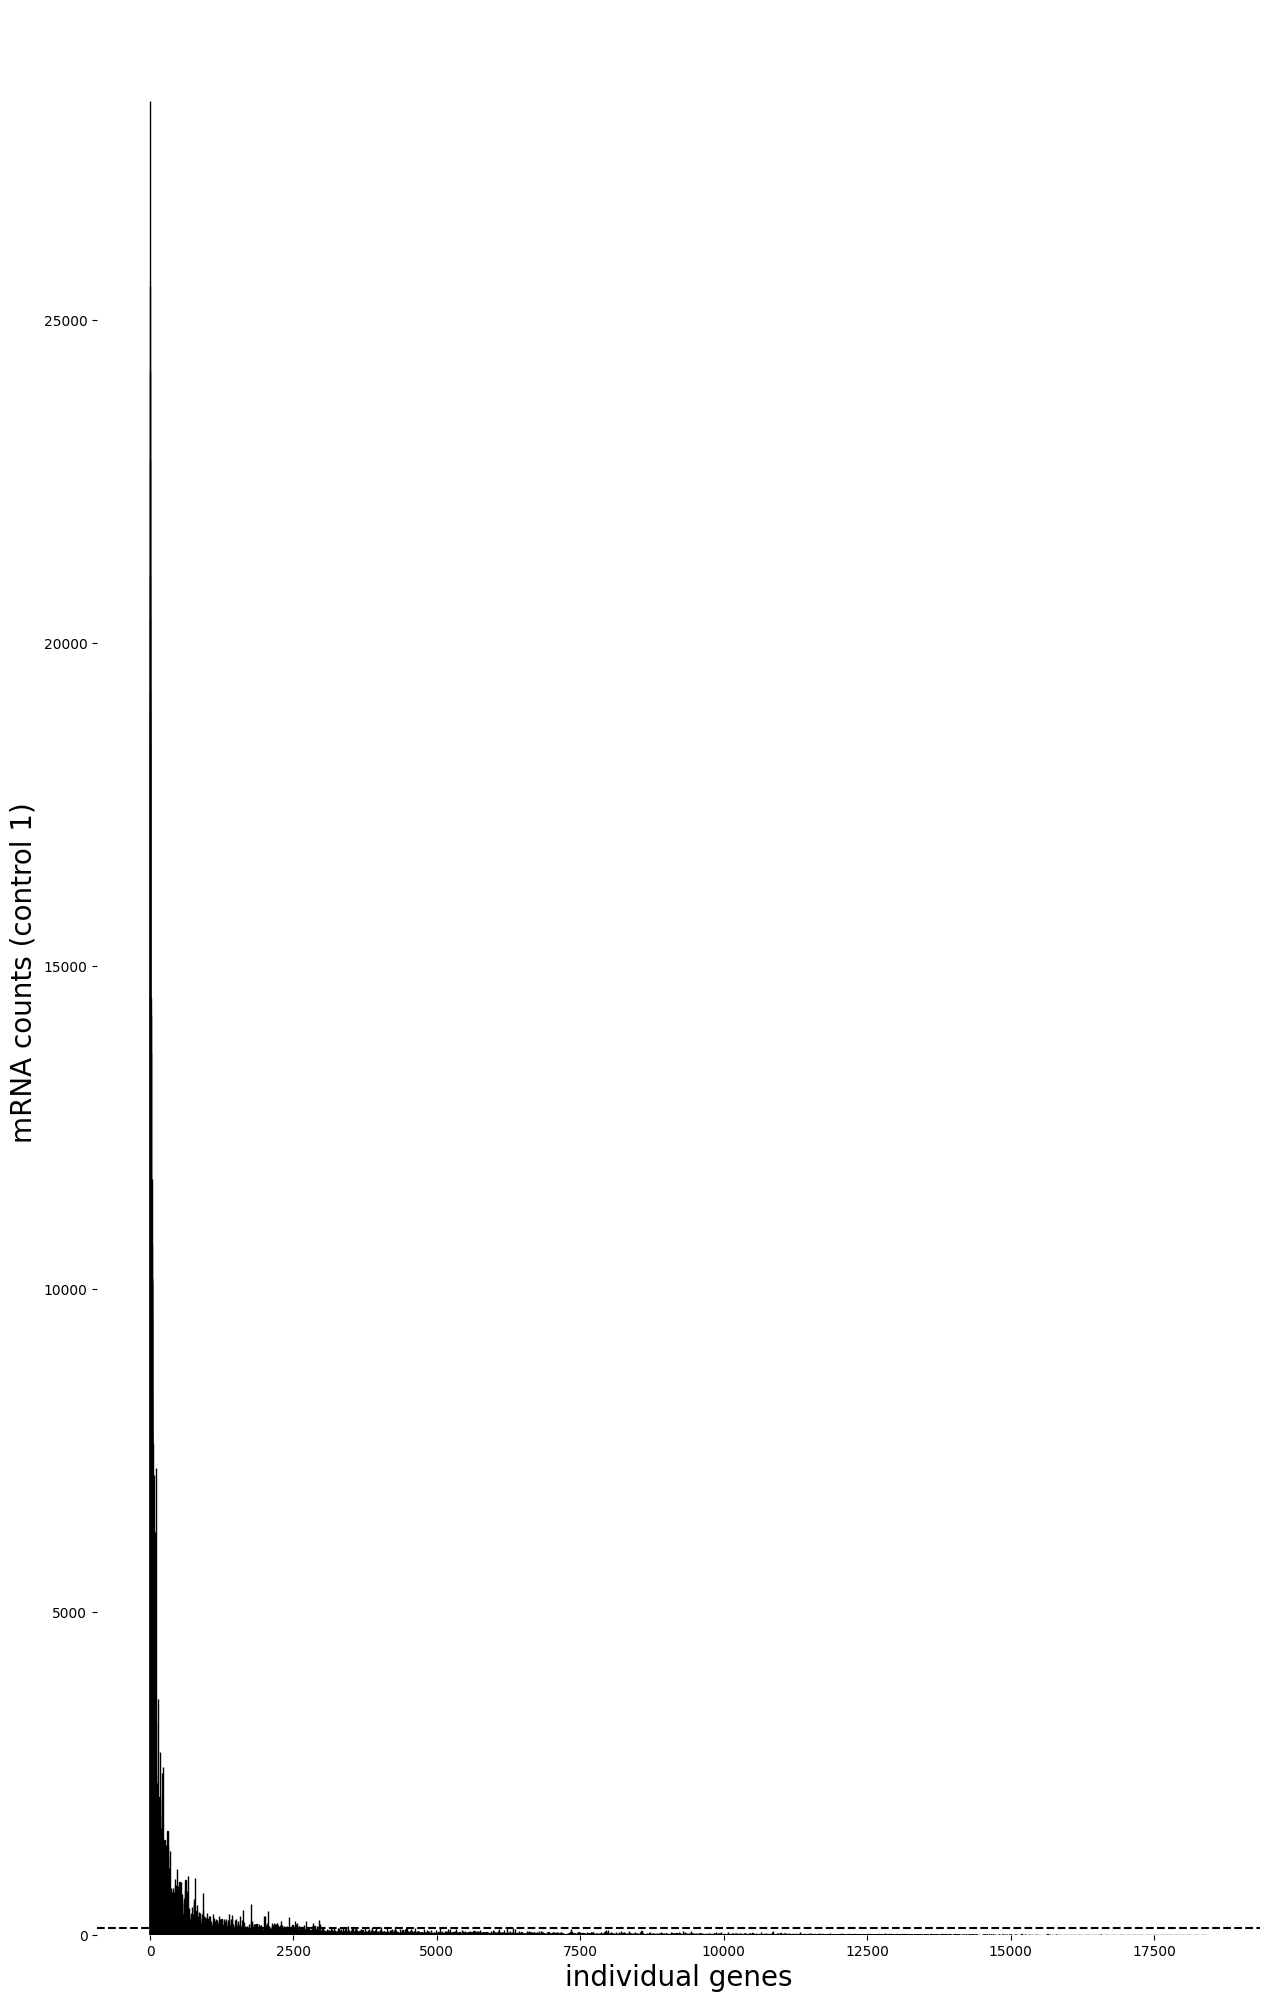

In [ ]:
#Make x range with the length of the dataframe
x = np.arange(len(df))
y = df['ck_1'].to_list()
bar_plot(x, y,
        x_label = 'individual genes',
         y_label = 'mRNA counts (control 1)'
        )

**Notes:**

The plotted data shows us that there are approximately 2500 genes that at some point in during the have RNA counts of >100. Most other genes are found to have < 100 counts.  

Additionally, as we saw before quite a lot of data points have RNA counts close to zero and as we are not interested in promoters that do not express anyhting. They can be filtered out.

### Setting an expression threshold:

We choose to put a threshold expression level - arbitrarily chosen and can differ from dataset to dataset. Genes with counts less than 300 counts combined in the 3 controls are filtered out.  


In [ ]:
threshold = 300
df_with_threshold = df[df['ck_1']+ df['ck_2']+ df['ck_3'] > threshold]
# adding an extra column with average of ck_1 to ck_3
df_with_threshold['ck_average'] = (df_with_threshold['ck_1']+df_with_threshold['ck_2']+df_with_threshold['ck_3'])/3
# adding an extra column with standard deviation of ck_1 to ck_3
df_with_threshold['ck_std']= df_with_threshold[['ck_1','ck_2','ck_3']].std(axis=1)

df_with_threshold

<ipython-input-10-504555dee5e4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_threshold['ck_average'] = (df_with_threshold['ck_1']+df_with_threshold['ck_2']+df_with_threshold['ck_3'])/3
<ipython-input-10-504555dee5e4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_threshold['ck_std']= df_with_threshold[['ck_1','ck_2','ck_3']].std(axis=1)


ck_1          ck_2          ck_3     Salt_2h_1  \
gene_id                                                                     
CHLREDRAFT_46276   28389.803010  18450.699590  23802.340680  46826.065170   
CHLREDRAFT_132716  24198.106490  14975.504660  14638.736500  30271.595250   
CHLREDRAFT_195605  22837.142410  14096.769540  12239.570730  28035.748100   
CHLREDRAFT_82172   19254.985570  13162.038170  16929.000200  21909.174630   
CHLREDRAFT_195584  20395.723260   9515.468759   8388.463632  20573.790410   
...                         ...           ...           ...           ...   
CHLREDRAFT_181909     49.882681    105.818585    166.990118      2.637868   
novel.3362           127.231525    131.944942    156.644387      0.000000   
CHLREDRAFT_121889     81.955126    114.593313    141.275841      1.263702   
CHLREDRAFT_187017     86.251137    105.108497    123.167647      0.704981   
CHLREDRAFT_183696    107.724177     65.620608    126.733341      2.362589   

                      Salt_2h_2     Salt_2h_3     Salt_4h_1     Salt_4h_2  \
gene_id                                                                     
CHLREDRAFT_46276   15044.048030  14574.441280  17904.730740  13978.674280   
CHLREDRAFT_132716  10388.870530   8965.308599  14227.589370  10726.211900   
CHLREDRAFT_195605  10325.394910  10156.866450  13617.781710  10937.648180   
CHLREDRAFT_82172    9175.024738   8505.188908  10885.844870   8573.861486   
CHLREDRAFT_195584   9420.561810   7379.889915  10659.893610  10013.819550   
...                         ...           ...           ...           ...   
CHLREDRAFT_181909      8.487572     18.820067     15.700850     13.589172   
novel.3362             3.938362      4.433573      2.113576      3.780577   
CHLREDRAFT_121889      1.234944      4.220329      3.166470      1.465901   
CHLREDRAFT_187017      1.082616      0.870532      2.194891      0.782225   
CHLREDRAFT_183696      0.924822      0.400427      0.801746      0.308407   

                      Salt_4h_3     Salt_8h_1  ...    Salt_48h_2  \
gene_id                                        ...                 
CHLREDRAFT_46276   17194.816690  14463.701590  ...  14187.766650   
CHLREDRAFT_132716  15604.009260  10857.340360  ...  10013.033830   
CHLREDRAFT_195605  13111.685910  10397.116140  ...  10552.944790   
CHLREDRAFT_82172    8388.424316  12030.260470  ...  12153.359770   
CHLREDRAFT_195584  15835.382290  12421.900280  ...  12324.014830   
...                         ...           ...  ...           ...   
CHLREDRAFT_181909      8.077800      5.395763  ...      9.103140   
novel.3362             4.504165      5.848765  ...      3.021301   
CHLREDRAFT_121889      1.303718      7.586362  ...      1.937828   
CHLREDRAFT_187017      0.380969      0.581120  ...      0.062919   
CHLREDRAFT_183696      0.657143      0.267304  ...      0.086824   

                     Salt_48h_3    Salt_72h_1    Salt_72h_2    Salt_72h_3  \
gene_id                                                                     
CHLREDRAFT_46276   18269.278380  43711.021150  16633.283900  14070.182550   
CHLREDRAFT_132716  14835.339270  34135.320940  15249.239050  11601.622240   
CHLREDRAFT_195605  14859.297710  33109.914330  15886.542660  11057.884160   
CHLREDRAFT_82172   17102.146160  27502.722170  15540.318980  13971.433920   
CHLREDRAFT_195584  15087.977480  30580.357970  13946.583690  13582.533020   
...                         ...           ...           ...           ...   
CHLREDRAFT_181909      6.500574      4.471223      8.038387      7.456820   
novel.3362             4.369045      6.230733      1.783163      4.815863   
CHLREDRAFT_121889      1.120119      1.665995      0.310635      2.110892   
CHLREDRAFT_187017      0.000000      0.000000      0.000000      0.213521   
CHLREDRAFT_183696      0.469052      0.732872      0.000000      0.245539   

                     Salt_96h_1    Salt_96h_2    Salt_96h_3    ck_average  \
gene_id                                                    

This step filtered out most of the genes with 1019 remaining promoters.

### Sorting the values
Sorting the values of the dataframe based on average expression in control:

In [ ]:
df_with_threshold = df_with_threshold.sort_values(by=['ck_average'], ascending = False)
df_with_threshold.head()

ck_1         ck_2         ck_3    Salt_2h_1  \
gene_id                                                                 
CHLREDRAFT_46276   28389.80301  18450.69959  23802.34068  46826.06517   
CHLREDRAFT_126163  18437.44382  15662.10278  22407.36029  30303.38831   
CHLREDRAFT_159282  25523.92532  13920.94883  16896.95725  27465.60677   
CHLREDRAFT_132716  24198.10649  14975.50466  14638.73650  30271.59525   
CHLREDRAFT_82172   19254.98557  13162.03817  16929.00020  21909.17463   

                      Salt_2h_2     Salt_2h_3    Salt_4h_1     Salt_4h_2  \
gene_id                                                                    
CHLREDRAFT_46276   15044.048030  14574.441280  17904.73074  13978.674280   
CHLREDRAFT_126163   9418.017775   9816.365202  13050.49501   8063.947507   
CHLREDRAFT_159282  10072.984370   7938.195881  11567.98644   9273.011446   
CHLREDRAFT_132716  10388.870530   8965.308599  14227.58937  10726.211900   
CHLREDRAFT_82172    9175.024738   8505.188908  10885.84487   8573.861486   

                      Salt_4h_3     Salt_8h_1  ...    Salt_48h_2  \
gene_id                                        ...                 
CHLREDRAFT_46276   17194.816690  14463.701590  ...  14187.766650   
CHLREDRAFT_126163  10149.177310   7231.270708  ...   5315.423143   
CHLREDRAFT_159282  12117.918610   9837.408357  ...   9349.500125   
CHLREDRAFT_132716  15604.009260  10857.340360  ...  10013.033830   
CHLREDRAFT_82172    8388.424316  12030.260470  ...  12153.359770   

                     Salt_48h_3   Salt_72h_1    Salt_72h_2    Salt_72h_3  \
gene_id                                                                    
CHLREDRAFT_46276   18269.278380  43711.02115  16633.283900  14070.182550   
CHLREDRAFT_126163   8616.925356  17082.13626   7199.082238   5141.831975   
CHLREDRAFT_159282  13153.781830  25594.06734  11694.176500  10373.780760   
CHLREDRAFT_132716  14835.339270  34135.32094  15249.239050  11601.622240   
CHLREDRAFT_82172   17102.146160  27502.72217  15540.318980  13971.433920   

                     Salt_96h_1    Salt_96h_2    Salt_96h_3    ck_average  \
gene_id                                                                     
CHLREDRAFT_46276   15277.780680  12118.186090  16834.963680  23547.614427   
CHLREDRAFT_126163   4886.631352   4347.001961   5261.915341  18835.635630   
CHLREDRAFT_159282  10037.279400   7434.661709  11152.155140  18780.610467   
CHLREDRAFT_132716  11189.551280   8000.383790  12087.370160  17937.449217   
CHLREDRAFT_82172   11207.376150  10157.293970  13469.220020  16448.674647   

                        ck_std  
gene_id                         
CHLREDRAFT_46276   4974.445527  
CHLREDRAFT_126163  3390.212716  
CHLREDRAFT_159282  6026.473093  
CHLREDRAFT_132716  5424.502311  
CHLREDRAFT_82172   3074.741694  

[5 rows x 29 columns]

## Now lets plot the 100 highest average expressing genes with std


The standard deviation is also ploted, as we want genes that expres uniformly across cells

Text(0.5, 1.0, 'Highest expressing genes')

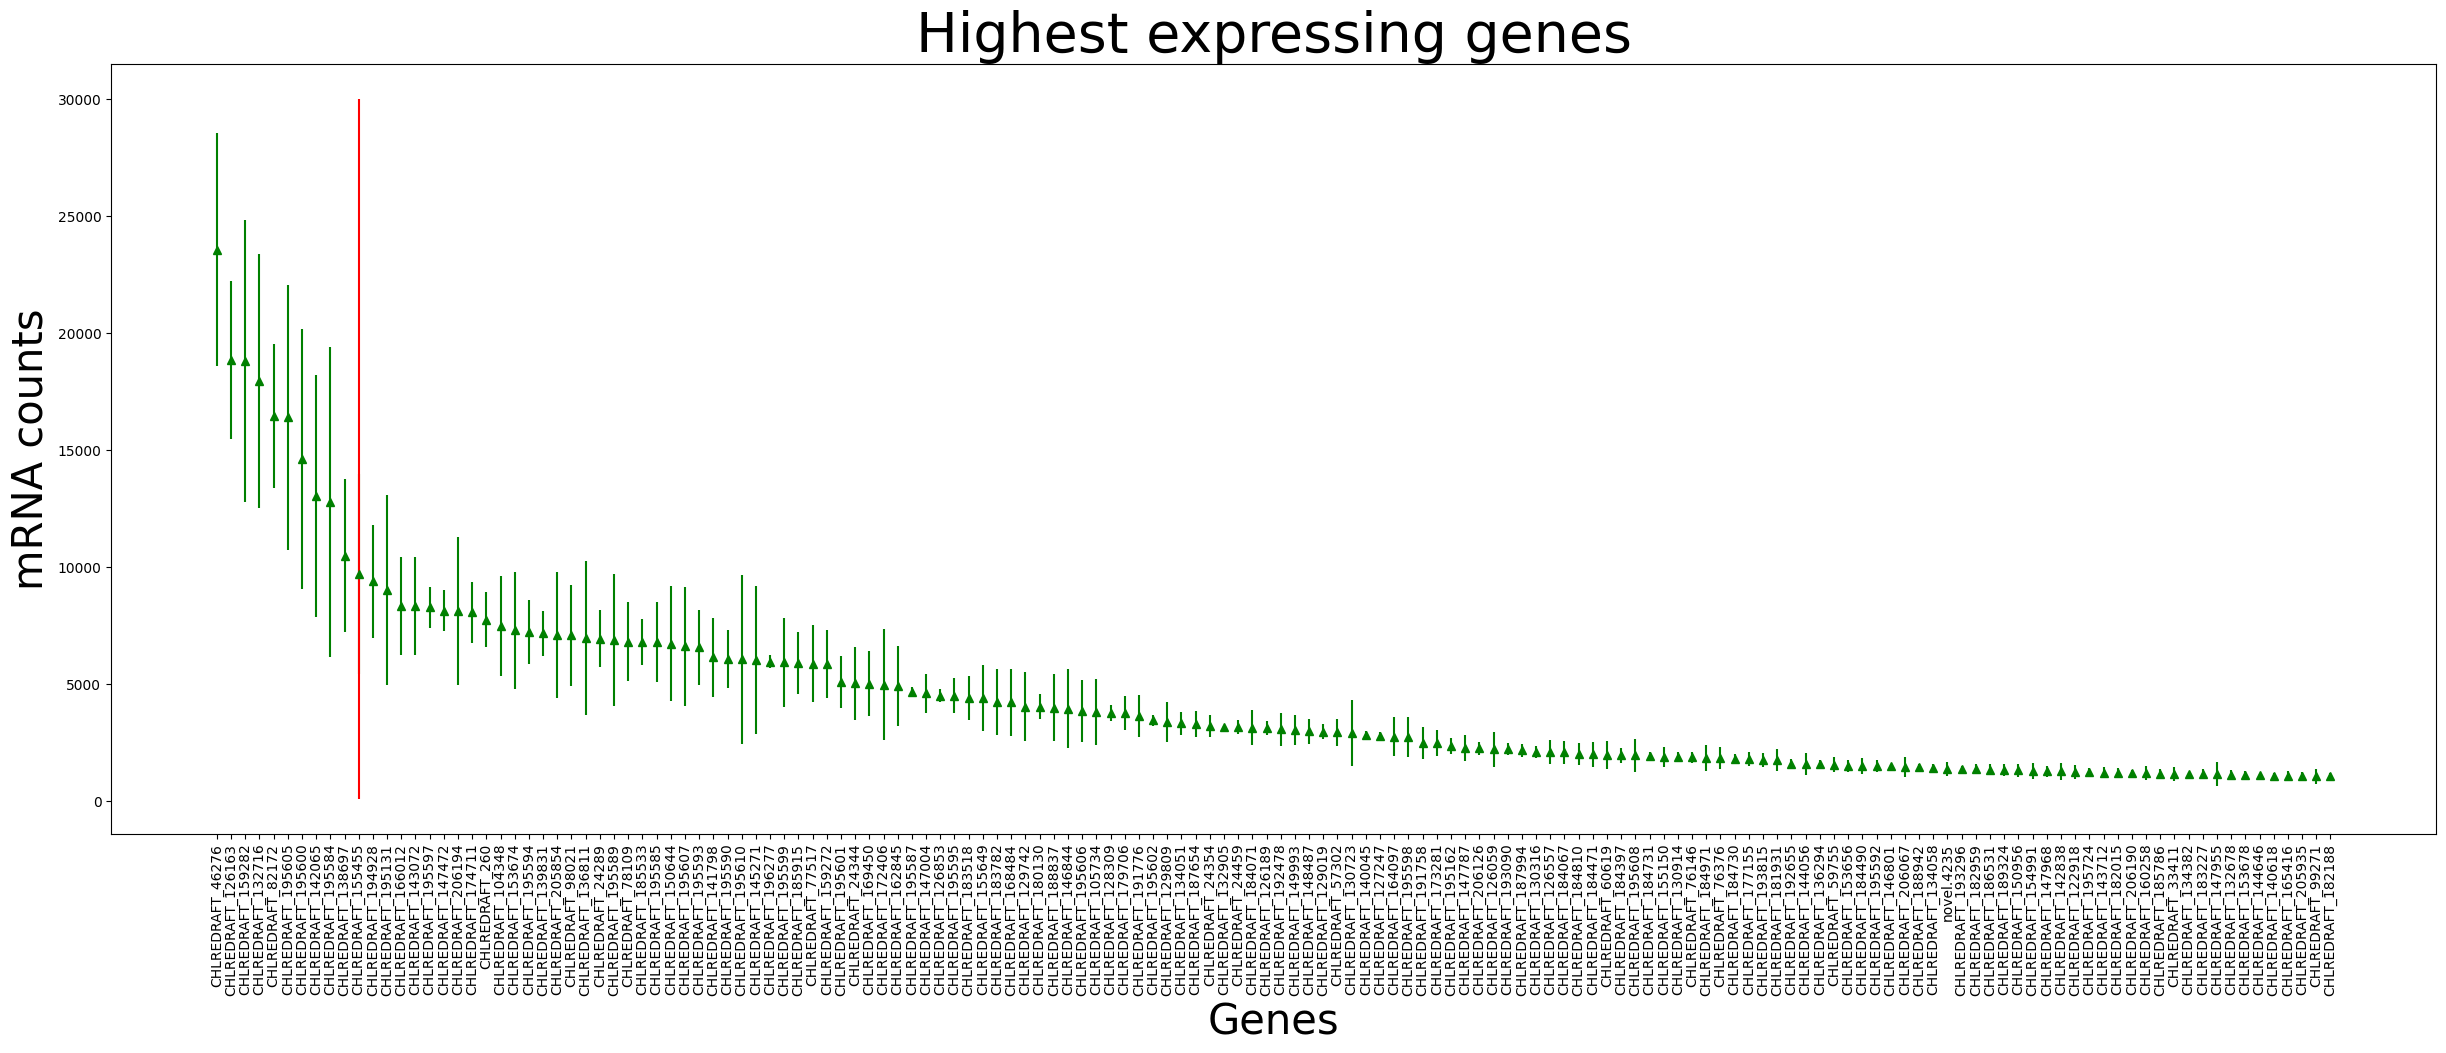

In [ ]:
#plot mean and standard deviation of ck_1 2 and 3
plt.figure(figsize=(30,10))
plt.errorbar(df_with_threshold[:150].index,df_with_threshold[:150]['ck_average'],df_with_threshold[:150]['ck_std'], linestyle='None', marker='^',color="green")
plt.xticks(rotation=90)
plt.vlines(df_with_threshold[:150].index[10],ymin=100,ymax=30000,color="red")
plt.xlabel('Genes', fontsize=30)
plt.ylabel('mRNA counts',fontsize=30)
plt.title('Highest expressing genes', fontsize=40)

### 2.3 Selecting the top 500 genes by average control expression

We can pick 500 genes with the highest counts and make them into a list.

In [ ]:
# Selecting top 500
List_of_Top100_High_control_prom = df_with_threshold[:500]

# making them into a list
List_of_Top100_High_control_promoters = List_of_Top100_High_control_prom.index.values.tolist()


Names of 500 most expressed genes:

In [ ]:
print(List_of_Top100_High_control_promoters)


['CHLREDRAFT_46276', 'CHLREDRAFT_126163', 'CHLREDRAFT_159282', 'CHLREDRAFT_132716', 'CHLREDRAFT_82172', 'CHLREDRAFT_195605', 'CHLREDRAFT_195600', 'CHLREDRAFT_142065', 'CHLREDRAFT_195584', 'CHLREDRAFT_138697', 'CHLREDRAFT_155455', 'CHLREDRAFT_194928', 'CHLREDRAFT_195131', 'CHLREDRAFT_166012', 'CHLREDRAFT_143072', 'CHLREDRAFT_195597', 'CHLREDRAFT_147472', 'CHLREDRAFT_206194', 'CHLREDRAFT_174711', 'CHLREDRAFT_260', 'CHLREDRAFT_104348', 'CHLREDRAFT_153674', 'CHLREDRAFT_195594', 'CHLREDRAFT_139831', 'CHLREDRAFT_205854', 'CHLREDRAFT_98021', 'CHLREDRAFT_136811', 'CHLREDRAFT_24289', 'CHLREDRAFT_195589', 'CHLREDRAFT_78109', 'CHLREDRAFT_185533', 'CHLREDRAFT_195585', 'CHLREDRAFT_150644', 'CHLREDRAFT_195607', 'CHLREDRAFT_195593', 'CHLREDRAFT_141798', 'CHLREDRAFT_195590', 'CHLREDRAFT_195610', 'CHLREDRAFT_145271', 'CHLREDRAFT_196277', 'CHLREDRAFT_195599', 'CHLREDRAFT_185915', 'CHLREDRAFT_77517', 'CHLREDRAFT_159272', 'CHLREDRAFT_195601', 'CHLREDRAFT_24344', 'CHLREDRAFT_169450', 'CHLREDRAFT_172406', '

## 3. Fetching promoter sequences

#### 3.1 We can now fetch the 1kb upstream of these promoters:

According to (Scranton et. al 2016 https://www.sciencedirect.com/science/article/pii/S2211926416300443) the promoters in C. reinhardtii can be regarded as 1 kb upstream.

First we load the genome into a dataframe

In [ ]:
## This reads the fasta file containing all the maped genes:
#download_cds=download_unzip_load('https://ftp.ebi.ac.uk/ensemblgenomes/pub/release-57/plants/fasta/chlamydomonas_reinhardtii/cds/Chlamydomonas_reinhardtii.Chlamydomonas_reinhardtii_v5.5.cds.all.fa.gz',fasta=True)
#genemaps=read_fasta_files(download_cds)

genemaps=read_fasta_files("Chlamydomonas_reinhardtii.v3.1.cds.all.fa")

#the following is just to show the loading
print(genemaps[:10])

[SeqRecord(seq=Seq('CTAGGTGTATCTAATGTCTGCTCGCTGGAGCTGGCTAGCGCCGATGACGCGGCG...CGG'), id='EDO96152', name='EDO96152', description='EDO96152 cds supercontig:v3.1:DS496234:41088:41802:-1 gene:CHLREDRAFT_96485 gene_biotype:protein_coding transcript_biotype:protein_coding description:Predicted protein [Source:UniProtKB/TrEMBL;Acc:A8JIZ6]', dbxrefs=[]), SeqRecord(seq=Seq('ATGGCGTGGTGCCAGTCCATTAGCCTGACACGGCCCGCAGGACTGGGCGCAGCT...TAC'), id='EDO96151', name='EDO96151', description='EDO96151 cds supercontig:v3.1:DS496234:1720:2446:1 gene:CHLREDRAFT_160450 gene_biotype:protein_coding transcript_biotype:protein_coding description:Predicted protein [Source:UniProtKB/TrEMBL;Acc:A8JIZ5]', dbxrefs=[]), SeqRecord(seq=Seq('ATGCGTTCACCTAGGCGCGCTAGCATTGTGTTGGCTCTGTTCTGTCTAGCATTA...TAA'), id='EDO97237', name='EDO97237', description='EDO97237 cds supercontig:v3.1:DS496178:59356:69533:1 gene:CHLREDRAFT_194578 gene_biotype:protein_coding transcript_biotype:protein_coding description:Metalloproteinase of VMP fa

### Loading and Putting the cDNA into DataFrame

In [ ]:

## This reads the fasta file containing all the maped genes:
cdna=read_fasta_files("Chlamydomonas_reinhardtii.v3.1.cdna.all.fa")

gene_name_l,sequence_l,mapping_l,mapping_id_l=[],[],[],[]
for entry in cdna:
    description=entry.description
    description=description.split(" ")
    gene_name=description[3].replace("gene:","")
    seqeunce=entry.seq
    mapping=description[2]
    mapping_id=mapping.split(":")
    mapping_id=mapping_id[2]

    gene_name_l.append(gene_name)
    sequence_l.append(seqeunce)
    mapping_l.append(mapping)
    mapping_id_l.append(mapping_id)



df_cdna = pd.DataFrame({'gene_name':gene_name_l,'sequence':sequence_l,'mapping':mapping_l,'mapping_id':mapping_id_l})
df_cdna.head(
)


gene_name                                           sequence  \
0   CHLREDRAFT_96485  (G, A, C, T, A, G, G, T, G, T, A, T, C, T, A, ...   
1  CHLREDRAFT_160450  (G, C, G, G, C, G, T, T, C, A, G, A, C, T, G, ...   
2  CHLREDRAFT_194578  (C, C, G, C, A, G, G, C, C, T, C, T, G, A, T, ...   
3  CHLREDRAFT_179628  (C, G, C, A, A, T, T, T, C, C, A, T, C, C, G, ...   
4  CHLREDRAFT_132861  (G, G, C, T, C, C, A, G, A, G, C, A, T, A, C, ...   

                                     mapping mapping_id  
0   supercontig:v3.1:DS496234:41088:41802:-1   DS496234  
1      supercontig:v3.1:DS496234:1720:2446:1   DS496234  
2    supercontig:v3.1:DS496178:59356:69533:1   DS496178  
3  supercontig:v3.1:DS496178:292308:295123:1   DS496178  
4  supercontig:v3.1:DS496178:408270:410569:1   DS496178

## Lets extract the locations of the top promoters using the loaded transcription file

First i do some testing on how to extract the genomic mapping

In [ ]:
print(len(genemaps))
# Lets make a dataframe containing gene name, seqence and mapping to geneome
#some testing
genemaps[0].description
genemaps[0].description.split(" ")
mapping=genemaps[0].description.split(" ")[2]
mapping_id=mapping.split(":")
print(mapping,mapping_id)
print("The mapping read id is "+ mapping_id[2] + "From "+mapping_id[3]+"to "+mapping_id[4] )

14489
supercontig:v3.1:DS496234:41088:41802:-1 ['supercontig', 'v3.1', 'DS496234', '41088', '41802', '-1']
The mapping read id is DS496234From 41088to 41802


The mapping are added to the dataframe

In [ ]:
df_genemaps = pd.DataFrame(columns=['gene_name','sequence','mapping','mapping_id','genomic_sequence','1kb upstream','cDNA','5UTR','ck_average','ck_std'])

gene_name_l,sequence_l,mapping_l,mapping_id_l=[],[],[],[]
for entry in genemaps:
    description=entry.description
    description=description.split(" ")
    gene_name=description[3].replace("gene:","")
    seqeunce=entry.seq
    mapping=description[2]
    mapping_id=mapping.split(":")
    mapping_id=mapping_id[2]

    gene_name_l.append(gene_name)
    sequence_l.append(seqeunce)
    mapping_l.append(mapping)
    mapping_id_l.append(mapping_id)
#fix this
df_genemaps=pd.DataFrame({'gene_name':gene_name_l,'sequence':sequence_l,'mapping':mapping_l,'mapping_id':mapping_id_l,'genomic_sequence':["-"]*len(gene_name_l),'1kb upstream':["-"]*len(gene_name_l),'cDNA':["-"]*len(gene_name_l),'5UTR':["-"]*len(gene_name_l),'ck_average':["-"]*len(gene_name_l),'ck_std':["-"]*len(gene_name_l)})


df_genemaps

gene_name                                           sequence  \
0       CHLREDRAFT_96485  (C, T, A, G, G, T, G, T, A, T, C, T, A, A, T, ...   
1      CHLREDRAFT_160450  (A, T, G, G, C, G, T, G, G, T, G, C, C, A, G, ...   
2      CHLREDRAFT_194578  (A, T, G, C, G, T, T, C, A, C, C, T, A, G, G, ...   
3      CHLREDRAFT_179628  (A, T, G, G, G, T, A, G, A, C, C, A, T, T, C, ...   
4      CHLREDRAFT_132861  (A, T, G, G, C, G, C, A, A, A, T, C, A, C, T, ...   
...                  ...                                                ...   
14484  CHLREDRAFT_168076  (A, T, G, G, C, G, A, G, C, G, C, T, C, C, G, ...   
14485  CHLREDRAFT_168128  (A, T, G, G, C, G, T, C, T, C, A, G, C, C, C, ...   
14486    CHLREDRAFT_8761  (A, T, G, G, C, A, A, C, T, C, G, A, T, T, G, ...   
14487  CHLREDRAFT_143066  (A, T, G, A, C, C, G, T, G, G, A, A, G, G, G, ...   
14488   CHLREDRAFT_93846  (T, G, T, G, A, A, A, C, G, G, C, C, C, T, G, ...   

                                            mapping mapping_id  \
0          supercontig:v3.1:DS496234:41088:41802:-1   DS496234   
1             supercontig:v3.1:DS496234:1720:2446:1   DS496234   
2           supercontig:v3.1:DS496178:59356:69533:1   DS496178   
3         supercontig:v3.1:DS496178:292308:295123:1   DS496178   
4         supercontig:v3.1:DS496178:408270:410569:1   DS496178   
...                                             ...        ...   
14484  supercontig:v3.1:DS496111:1081294:1094581:-1   DS496111   
14485   supercontig:v3.1:DS496111:1581965:1598635:1   DS496111   
14486   supercontig:v3.1:DS496111:2179520:2181262:1   DS496111   
14487   supercontig:v3.1:DS496111:1615058:1617658:1   DS496111   
14488   supercontig:v3.1:DS496111:1999894:2000510:1   DS496111   

      genomic_sequence 1kb upstream cDNA 5UTR ck_average ck_std  
0                    -            -    -    -          -      -  
1                    -            -    -    -          -      -  
2                    -            -    -    -          -      -  
3                    -            -    -    -          -      -  
4                    -            -    -    -          -      -  
...                ...          ...  ...  ...        ...    ...  
14484                -            -    -    -          -      -  
14485                -            -    -    -          -      -  
14486                -            -    -    -          -      -  
14487                -            -    -    -          -      -  
14488                -            -    -    -          -      -  

[14489 rows x 10 columns]

In [ ]:
#confirmation of dataset
print(type(df_genemaps['sequence'][0]),len(df_genemaps['sequence'][0]))
df_genemaps['sequence'][0]

<class 'Bio.Seq.Seq'> 367


Seq('CTAGGTGTATCTAATGTCTGCTCGCTGGAGCTGGCTAGCGCCGATGACGCGGCG...CGG')

## The full genome with its ID is added to a pd dataframe

In [ ]:
genome=read_fasta_files("Chlamydomonas_reinhardtii.v3.1.dna.toplevel.fa")

df_genome=pd.DataFrame(columns=['id','sequence'])
id_list=[]
sequence_list=[]
for index,entry in enumerate(genome):
    id=entry.id
    sequence=entry.seq
    id_list.append(id)
    sequence_list.append(sequence)

df_genome=pd.DataFrame({'id':id_list,'sequence':sequence_list})
df_genome

id                                           sequence
0     DS496108  (G, G, G, C, T, G, G, G, C, G, C, T, G, A, C, ...
1     DS496109  (A, C, C, C, T, A, A, A, A, C, C, C, G, A, A, ...
2     DS496110  (T, C, G, C, G, A, C, T, G, T, T, G, T, G, C, ...
3     DS496111  (T, G, T, G, G, G, G, G, C, T, C, A, G, G, C, ...
4     DS496112  (C, A, G, C, G, G, C, A, T, T, G, G, G, G, T, ...
...        ...                                                ...
1553  DS497662  (G, T, C, G, T, C, A, T, A, A, A, G, G, C, T, ...
1554  DS497663  (C, C, C, G, C, G, C, G, C, T, G, G, G, A, G, ...
1555  DS497664  (T, G, C, T, G, C, T, G, G, C, C, A, T, G, C, ...
1556  DS497327  (T, T, G, T, T, G, T, T, G, G, C, C, C, C, G, ...
1557  DS497326  (T, G, C, A, G, A, C, A, C, G, A, G, C, A, G, ...

[1558 rows x 2 columns]

### Extract the Genomic Sequence corresponding to the CDS mappings

In [ ]:
#The start and stop index are extracted from the mapping colunm
df_100_highest_control=df_genemaps[df_genemaps['gene_name'].isin(List_of_Top100_High_control_promoters)]
df_100_highest_control['index_start']=df_100_highest_control['mapping'].apply(lambda x: x.split(":")[3])
df_100_highest_control['index_stop']=df_100_highest_control['mapping'].apply(lambda x: x.split(":")[4])
df_100_highest_control['strand']=df_100_highest_control['mapping'].apply(lambda x: x.split(":")[5])

#CHLREDRAFT_140045 is there twice because it has two isoforms thus the the df_100 higest has length 101
print(sorted(df_100_highest_control["gene_name"].to_list()))
print(sorted(List_of_Top100_High_control_promoters))


#Now lets extract the sequence from index_start to index_stop for each gene in df_100_highest_control.
#The sequence is in df_genome

for index, row in df_100_highest_control.iterrows():

    #Add cdna to df
    df_100_highest_control.loc[index,'cDNA']=df_cdna[df_cdna['gene_name']==row['gene_name']]['sequence'].iloc[0]

    #Adding the ck_average and ck_std to the dataframe
    df_100_highest_control.loc[index,'ck_average']=df_with_threshold.loc[row['gene_name'],'ck_average']
    df_100_highest_control.loc[index,'ck_std']=df_with_threshold.loc[row['gene_name'],'ck_std']

    #Because there are two different strands:
    if row['strand']==str(1):
        df_100_highest_control.loc[index,'genomic_sequence']=df_genome[df_genome['id']==row['mapping_id']]['sequence'].iloc[0][int(row['index_start'])+1:int(row['index_stop'])+1]
        df_100_highest_control.loc[index,'1kb upstream']=df_genome[df_genome['id']==row['mapping_id']]['sequence'].iloc[0][int(row['index_start'])+1-1000:int(row['index_start'])+1]

    elif row['strand']==str(-1):
        forward_genomic_sequence=df_genome[df_genome['id']==row['mapping_id']]['sequence'].iloc[0][int(row['index_start'])+1:int(row['index_stop'])+1]
        forward_1kb_upstream=df_genome[df_genome['id']==row['mapping_id']]['sequence'].iloc[0][int(row['index_stop'])+1:int(row['index_stop'])+1+1000]

        #These should be reverse complimented
        df_100_highest_control.loc[index,'genomic_sequence']=forward_genomic_sequence.reverse_complement()
        df_100_highest_control.loc[index,'1kb upstream']=forward_1kb_upstream.reverse_complement()



#Write excel and head
df_100_highest_control.to_excel("100_highest_control.xlsx")
df_100_highest_control.head()








<ipython-input-21-87e7d46ea916>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_100_highest_control['index_start']=df_100_highest_control['mapping'].apply(lambda x: x.split(":")[3])
<ipython-input-21-87e7d46ea916>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_100_highest_control['index_stop']=df_100_highest_control['mapping'].apply(lambda x: x.split(":")[4])
<ipython-input-21-87e7d46ea916>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

['CHLREDRAFT_102917', 'CHLREDRAFT_103549', 'CHLREDRAFT_104003', 'CHLREDRAFT_104136', 'CHLREDRAFT_104348', 'CHLREDRAFT_105734', 'CHLREDRAFT_106906', 'CHLREDRAFT_109250', 'CHLREDRAFT_114525', 'CHLREDRAFT_114692', 'CHLREDRAFT_116226', 'CHLREDRAFT_118177', 'CHLREDRAFT_118754', 'CHLREDRAFT_120341', 'CHLREDRAFT_121064', 'CHLREDRAFT_122124', 'CHLREDRAFT_122688', 'CHLREDRAFT_122918', 'CHLREDRAFT_126059', 'CHLREDRAFT_126163', 'CHLREDRAFT_126189', 'CHLREDRAFT_126203', 'CHLREDRAFT_126226', 'CHLREDRAFT_126557', 'CHLREDRAFT_126810', 'CHLREDRAFT_126853', 'CHLREDRAFT_126960', 'CHLREDRAFT_127247', 'CHLREDRAFT_128309', 'CHLREDRAFT_128523', 'CHLREDRAFT_128745', 'CHLREDRAFT_129019', 'CHLREDRAFT_129128', 'CHLREDRAFT_129468', 'CHLREDRAFT_129742', 'CHLREDRAFT_129809', 'CHLREDRAFT_129968', 'CHLREDRAFT_130093', 'CHLREDRAFT_130316', 'CHLREDRAFT_130723', 'CHLREDRAFT_130914', 'CHLREDRAFT_132194', 'CHLREDRAFT_132210', 'CHLREDRAFT_132678', 'CHLREDRAFT_132716', 'CHLREDRAFT_132881', 'CHLREDRAFT_132888', 'CHLREDRAFT_

gene_name                                           sequence  \
34   CHLREDRAFT_185786  (A, T, G, T, C, G, A, C, T, T, C, C, G, G, T, ...   
62   CHLREDRAFT_195610  (A, T, G, C, G, C, G, C, T, A, A, G, T, G, G, ...   
80   CHLREDRAFT_184731  (A, T, G, C, T, C, G, C, G, A, A, C, G, T, C, ...   
108   CHLREDRAFT_24289  (A, T, G, G, C, T, G, A, C, G, C, C, G, C, C, ...   
127  CHLREDRAFT_184730  (A, T, G, C, T, C, G, C, G, A, A, C, G, T, C, ...   

                                          mapping mapping_id  \
34     supercontig:v3.1:DS496178:333411:335771:-1   DS496178   
62     supercontig:v3.1:DS496136:747913:748282:-1   DS496136   
80    supercontig:v3.1:DS496136:1140439:1142596:1   DS496136   
108      supercontig:v3.1:DS496136:23427:23989:-1   DS496136   
127  supercontig:v3.1:DS496136:1127952:1130177:-1   DS496136   

                                      genomic_sequence  \
34   (A, C, T, C, A, C, A, C, C, A, A, G, C, A, C, ...   
62   (A, G, A, A, A, A, A, T, G, C, G, C, G, C, T, ...   
80   (A, C, A, G, C, G, C, A, C, T, C, G, C, C, T, ...   
108  (C, G, T, C, A, G, G, C, T, C, G, T, A, G, T, ...   
127  (G, T, T, C, T, A, T, C, T, G, C, T, T, G, C, ...   

                                          1kb upstream  \
34   (T, G, C, T, G, G, T, G, C, T, T, C, T, G, C, ...   
62   (A, A, C, C, G, G, A, G, C, A, G, T, A, T, G, ...   
80   (C, T, G, C, G, T, C, A, G, C, C, T, G, C, C, ...   
108  (G, C, G, G, G, A, G, A, C, A, T, G, C, G, G, ...   
127  (N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ...   

                                                  cDNA 5UTR   ck_average  \
34   (C, T, C, A, C, A, C, C, A, A, G, C, A, C, T, ...    -  1167.954668   
62   (G, A, A, A, A, A, T, G, C, G, C, G, C, T, A, ...    -  6050.899908   
80   (T, T, A, C, A, G, C, G, C, A, C, T, C, G, C, ...    -  1911.846015   
108  (G, T, C, A, G, G, C, T, C, G, T, A, G, T, T, ...    -  6933.269003   
127  (T, T, C, T, A, T, C, T, G, C, T, T, G, C, T, ...    -   1817.44907   

          ck_std index_start index_stop strand  
34    191.429689      333411     335771     -1  
62   3618.476666      747913     748282     -1  
80    189.715093     1140439    1142596      1  
108  1213.989686       23427      23989     -1  
127   200.573057     1127952    1130177     -1

### Write the promoters in fasta file

In [ ]:
#write a fasta with seq.IO for the promoters
df_100_highest_control=df_100_highest_control.sort_values(by=['ck_average'], ascending = False)
with open("100_highest_control_promoters.fasta", "w") as output_handle:
    records=[]
    for index,row in df_100_highest_control.iterrows():
        if len(row['1kb upstream'])==1000 and not 'N' in row['1kb upstream']:
            records.append(SeqRecord(row['1kb upstream'],id=row['gene_name'],description=row['mapping']))
    #print(records)
    SeqIO.write(records, output_handle, "fasta")

## 4. Check for Homology between promoters with multiple sequence alingment

In [ ]:
from Bio.Align import MultipleSeqAlignment
High_control_promoters = read_fasta_files("100_highest_control_promoters.fasta")
All_promoters =  High_control_promoters
for i in All_promoters:
    if not len(i.seq)==1000:
        print(i.id)


align = MultipleSeqAlignment(All_promoters)
for record in align:
    print(record.seq[0:100] + " " + record.id)# print(align.substitutions)

CGGCCGTAGTCTAAAGCCACCCTCTTTAACAGCACGACCGCTATCGCATACATGCACCCCTAACCGCACGGCACGCCGTTCCCATGTCACTCACAATCTT CHLREDRAFT_46276
TGATAGCTATGGCGGCGTGTATATGCTGGTCCTCCGGCACGGCGGGACGGGCCAGAGATGCAGCATGGTCGTGCTGTCTGTGCAGCGTCTATCATTCATG CHLREDRAFT_126163
AAGCACGTCCATAATGAAAGGTCCGTGACTCATGAAGCCAGCACACACGTGATGATATCGTTCCGCTGTGGCTGGGGTGGAGCCTTCGTCAATACGGTAA CHLREDRAFT_159282
CGCTTCCGTCTGTCAACACCTCCCGGCCGACGTAGCAGAGCTGGTTGCGAGAGAATATGTTGCCGCTGTCCAGCAGCTCCAGGAACATCGGCTGCAGCTC CHLREDRAFT_132716
CCCTGCCCCGCCCGCCGATCCCGCACGGCAGGTGCCTGCCGCCCCCGGGGCCTGCCGTACTGCCTTGTAGCATCCCGCCATGCTACCACCGCCGTACGCA CHLREDRAFT_82172
CTGAGCAGAATCGCTGGAGAAGCCCTGAGACCCCAAAGTCCCTCCCCACAAACGGACACGTCTGAGGCGTCACGCCCTCCCAAGGCAGCAGTTTGCCAGC CHLREDRAFT_195605
CTGACCTTTCGCACAGCTAGTACCACCCCGCCACACTACACCAGTACCGCTCTGACCACAGGAATCCACGGGCTGTCCTCGCTGTTGCTGCTCGCCAGCA CHLREDRAFT_195600
GCCCCGCCTCGCCCACCTGTCCCAGAACGCGGCGTGCTGCTGCAACACGGTGTAGGTGGGTATGCTCAACCCCTTGCTGCCTTCCGGGTGCTTACTGTCC CHLREDRAFT_142065
GCAACCGGACAGGCATCCCCCCACACACTCCACAGCGCGGACAGCTCGCT

With biopython it is possible to align sequences in what is termed a "DUMMY ALIGNMENT" - see below

In [ ]:
from Bio.Align import AlignInfo
summary_align = AlignInfo.SummaryInfo(align)
gap_consensus = summary_align.gap_consensus()
consensus = summary_align.dumb_consensus( threshold=0.7)
print(consensus)

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

In [ ]:
counter = 0
for nucleotide in consensus:
    if nucleotide != 'X':
        counter += 1

print('Amount of consensus with a 70% threshold: ', (counter/len(consensus))*100, '%')
print('Nucleotides that are the same at a 70% threshold:', counter)

Amount of consensus with a 70% threshold:  0.0 %
Nucleotides that are the same at a 70% threshold: 0


From these results we dont see any long stretches of homology which intuitively makes sense since that would cause genetic instability

### No we do pairwise alignment of CDS sequences and the full genetic seqeunce (extracted from the genome mapping)

This reveals the exons and introns

In [ ]:
for index, row in df_100_highest_control.iterrows():
    seq1,seq2 = row["genomic_sequence"],row["sequence"]
    #alignments = pairwise2.align.globalxx(seq1, seq2,one_alignment_only=True)
    alignments=pairwise2.align.localms(seq1, seq2, match=2, mismatch=-10, open=-5,extend=-.05,one_alignment_only=True,penalize_end_gaps=(True,False))
    for alignment in alignments:
        print(row['gene_name'])
        print(format_alignment(*alignment))


CHLREDRAFT_46276
2 ACGAAGAAGCGGCGGAATCGGGGACGCGCCAAGCACGGCCGCGGCCATGTGAACCGTGTGCGCTGCGAGTCTAGCGGCGCCATGGTGCCCAAGGACAAGGCTATCAAGCGCTACATTGTGCGCAACATTGTGGACGCGTCGGCTCTCCGCGACATGCAGGAGGCTTGCGTCGTCGACAGTGAGTCGGCGGAGGGACGGCTGTGGGCGCTGGGGATCGAGCCTGGGCGACGGCCTCCAGTTGGGCTGGCTTGGGATAGCAATAGGTCATGACAATATGAAATGAAGTGGATGAGGACCGAGTGTGCTCATTTTAGCGCGAGGGCGTGTTTGTCCGCCGTCTTGAGGCTTCTGCCGGCGCAATCCCTGCCCACAGACTACGCCCTGCCCAAGATTTACCGCAAGGTGTACTACAGCATCAGCGCTGCTATCCACAGCCGCGTTGTGCGCGTCCGCAACGCCAAGGAGCGCCGGAACCGGGAGCCGCCTCGCCGGTTC
  ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||                                                                                                                                                                                                   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

/usr/local/lib/python3.10/dist-packages/Bio/pairwise2.py:556: BiopythonWarning: "penalize_end_gaps" should not be used in local alignments. The resulting score may be wrong.
  warnings.warn(


CHLREDRAFT_126163
18 ATGGGCAAGAAGGGCAAGGGTACCGGAAGCTTCGGTAAGTGTGCTGCCGCCGCATTTAGACGAAATTCGCGCTGCTGGGGCCTGCTCTGAGTCTTGTGCTGATCCTTTGCCTGTGAAATGCCTTACAGGTAAGCGCCGCAACAAGACGCACACTCTGTGCCGTCGTTGCGGTCGCACCAGCTACCACAACCAGAAGCACGTCTGCTCGGCGTGCGGCTACCCTGCTGCCCGCAAGCGGACTTGTGAGTGAAGAATCACTGAAGGGCGACCTTGGACGGCAGCTGGGACAGCGGAGCTCAGGGCTTTGTCGGCGCCGCAGCCATCTCGCAGCGGGGCTCGTCCGCGGGCTGCTGAACGTTATTTCTGGAGATAGCTCTTGTTGTTGAATGCTTCGGACACAGCCGGTGCTGACACCTGGGCCGCCGTTTTCCCTTGGGATTGCAGACCAGTGGGGGCAGAAGGCCATTGGCCGCAAGACCACCGGCTCCGGCCGCATGCGGTACATGAAGACGCTGGCCCGGCGCTTCAAGAACGGCTTCCGCGAGGGTAGGCGTGGGCTGGGCTGCATGCGGTGATGGTCGGCAGCGAGCTCTATTTTCGGGGGCTTTGCCTGTATATAAGGGTATTGTGCAGTTGAGAAATGAGCGATTGCTCACGTCGCATCTGGTGGCGAGCAAGCATCGTCCGGCACAGCCTGCGCAAACGCGGGTCCCTGACGCCGGAGGAGCTCTCGGCACCCTCCCGCCGCCCCCGGCCGGCATGCCTCTAGGATGCGGGCTCGCATGCGCTGACAGCAGATGAGTGCGGTTTGCTGTGGGAAATCCCACTGCATTCATGGCAGGTTGCATGACCCCCTCGCCTTGCCTCAACCCTGGGTGCCCCCTGCCCCTGCTCTTCCGTGCTGTGCGCGCAGGCTCTGAGGCCAAGCCCAAGGTGGCGACCGCCTAA
   |||||||||||||||||||||||||||

### Lets try to get the 5' UTR (another better approach is used below)
In this code, we map the first 6 and 3 nucleotides of the CDS to the genomic sequence. But it turns out there is an easier way to get the 5' UTR which will be done below


In [ ]:
df_sorted=df_100_highest_control.sort_values(by=['ck_average'], ascending = False)
for index, row in df_100_highest_control.iterrows():
    seq_genomic,seq_cds = row["genomic_sequence"],row["sequence"]
    if seq_cds[0:5] in seq_genomic:
        #find index of seq_cds[0:3] in seq_genomic
        index=seq_genomic.find(seq_cds[0:6])

        print(row['gene_name'],seq_cds[0:6], "is in position " ,index)

    else:
        print(row['gene_name'],seq_cds[0:6], "is not in genomic sequence")
    if seq_cds[0:3] in seq_genomic:

        index2 =seq_genomic.find(seq_cds[0:3])
        print("The start codon " + seq_cds[0:3] +" is in position ",index2)

CHLREDRAFT_46276 ATGACG is in position  -1
The start codon ATG is in position  47
CHLREDRAFT_126163 ATGGGC is in position  17
The start codon ATG is in position  17
CHLREDRAFT_159282 ATGGCG is in position  6
The start codon ATG is in position  6
CHLREDRAFT_132716 ATGGGC is in position  686
The start codon ATG is in position  25
CHLREDRAFT_82172 ATGTCG is in position  1
The start codon ATG is in position  1
CHLREDRAFT_195605 ATGGGC is in position  564
The start codon ATG is in position  25
CHLREDRAFT_195600 ATGCGT is in position  35
The start codon ATG is in position  35
CHLREDRAFT_142065 ATGCAG is in position  40
The start codon ATG is in position  40
CHLREDRAFT_195584 ATGGGT is in position  -1
The start codon ATG is in position  101
CHLREDRAFT_138697 ATGCCG is in position  13
The start codon ATG is in position  13
CHLREDRAFT_155455 ATGACC is in position  36
The start codon ATG is in position  36
CHLREDRAFT_194928 ATGCCG is not in genomic sequence
The start codon ATG is in position  22

### No we do pairwise alignment of cDNA  and the full genetic seqeunce
Here we validate that the start of the mapping is actually the TSS

In [ ]:
count=1
for index, row in df_100_highest_control.iterrows():
    if count==100:
      break
    seq1,seq2 = row["genomic_sequence"],row["cDNA"]
    #alignments = pairwise2.align.globalxx(seq1, seq2,one_alignment_only=True)
    alignments=pairwise2.align.localms(seq1, seq2, match=2, mismatch=-10, open=-5,extend=-.05,one_alignment_only=True,penalize_end_gaps=(True,False))
    for alignment in alignments:
        print(row['gene_name'])
        print(format_alignment(*alignment))
    count=count+1

CHLREDRAFT_46276
2 ACGAAGAAGCGGCGGAATCGGGGACGCGCCAAGCACGGCCGCGGCCATGTGAACCGTGTGCGCTGCGAGTCTAGCGGCGCCATGGTGCCCAAGGACAAGGCTATCAAGCGCTACATTGTGCGCAACATTGTGGACGCGTCGGCTCTCCGCGACATGCAGGAGGCTTGCGTCGTCGACAGTGAGTCGGCGGAGGGACGGCTGTGGGCGCTGGGGATCGAGCCTGGGCGACGGCCTCCAGTTGGGCTGGCTTGGGATAGCAATAGGTCATGACAATATGAAATGAAGTGGATGAGGACCGAGTGTGCTCATTTTAGCGCGAGGGCGTGTTTGTCCGCCGTCTTGAGGCTTCTGCCGGCGCAATCCCTGCCCACAGACTACGCCCTGCCCAAGATTTACCGCAAGGTGTACTACAGCATCAGCGCTGCTATCCACAGCCGCGTTGTGCGCGTCCGCAACGCCAAGGAGCGCCGGAACCGGGAGCCGCCTCGCCGGTTC
  ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||                                                                                                                                                                                                   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

### Getting 5' UTR by Pairwise alignment of CDS and cDNA
In the source of the genomic DNA and CDS of C. reinhardtii we also found a file specifying the cDNA sequences. Here we do an alignment of the CDS to the cDNA to find the 5' UTR. This is added to the DataFrame

In [ ]:
# In this code i want to do a pairwise alignment between the genomic sequence and the cds sequence.
for index, row in df_100_highest_control.iterrows():
    seq_cdna,seq_cds = row["cDNA"],row["sequence"]
    index_cdna=seq_cdna.find(seq_cds[0:6]) # find the index where the cds maps to the cDNA to find the 5' UTR
    df_100_highest_control.loc[index,'5UTR']=row['cDNA'][0:index_cdna] # add the 5' UTR to the dataframe
    alignments=pairwise2.align.localms(seq_cdna, seq_cds, match=2, mismatch=-10, open=-5,extend=-.05,one_alignment_only=True,penalize_end_gaps=(False,False))
    for alignment in alignments:
        print(row['gene_name'])
        print(format_alignment(*alignment))



CHLREDRAFT_46276
ATGACGAAGAAGCGGCGGAATCGGGGACGCGCCAAGCACGGCCGCGGCCATGTGAACCGTGTGCGCTGCGAGTCTAGCGGCGCCATGGTGCCCAAGGACAAGGCTATCAAGCGCTACATTGTGCGCAACATTGTGGACGCGTCGGCTCTCCGCGACATGCAGGAGGCTTGCGTCGTCGACAACTACGCCCTGCCCAAGATTTACCGCAAGGTGTACTACAGCATCAGCGCTGCTATCCACAGCCGCGTTGTGCGCGTCCGCAACGCCAAGGAGCGCCGGAACCGGGAGCCGCCTCGCCGGTTC
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
ATGACGAAGAAGCGGCGGAATCGGGGACGCGCCAAGCACGGCCGCGGCCATGTGAACCGTGTGCGCTGCGAGTCTAGCGGCGCCATGGTGCCCAAGGACAAGGCTATCAAGCGCTACATTGTGCGCAACATTGTGGACGCGTCGGCTCTCCGCGACATGCAGGAGGCTTGCGTCGTCGACAACTACGCCCTGCCCAAGATTTACCGCAAGGTGTACTACAGCATCAGCGCTGCTATCCACAGCCGCGTTGTGCGCGTCCGCAACGCCAAGGAGCGCCGGAACCGGGAGCCGCCTCGCCGGTTC
  Score=606

CHLREDRAFT_126163
20 ATGGGCAAGAAGGGCAAGGGTACCGGAAGCTTCGGTA

#Plotting the length of the UTR vs the ck_average

Text(0.5, 1.0, "Length of 5' UTR vs average expression")

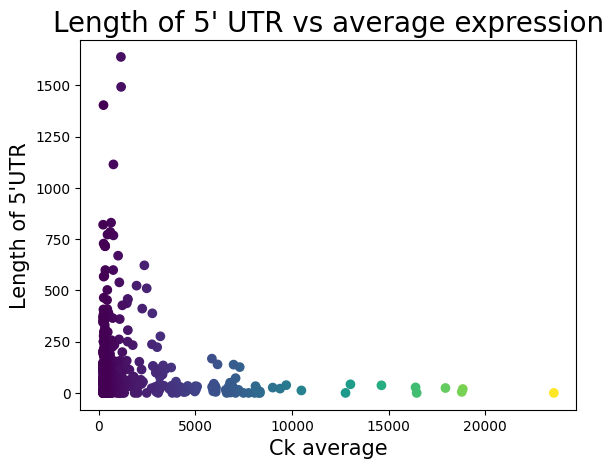

In [ ]:
# check the dataframe
df_100_highest_control.to_excel("100_highest_control.xlsx")
df_100_highest_control.head(10)

df_sorted=df_100_highest_control.sort_values(by=['ck_average'], ascending = False)
# sort the dataframe by ck average
#print(np.arange(0,len(df_100_highest_control.index)),df_100_highest_control.sort_values(by=['ck_average'], ascending = False)["5UTR"].apply(lambda x: len(x)).to_list())
plt.scatter(df_sorted['ck_average'].to_list(),df_sorted["5UTR"].apply(lambda x: len(x)).to_list(), c=df_sorted["ck_average"].to_list(), cmap='viridis')
plt.xlabel("Ck average",fontsize=15)
plt.ylabel("Length of 5'UTR",fontsize=15)
plt.title("Length of 5' UTR vs average expression",fontsize=20)

## Write a Fasta with the UTRs
This is done in two different files because the combinatorial library is designed in two different ways (depending on wether it can be as a padding or needs to be a PCR amplified fragment)


In [ ]:
# sort df based on ck average
df_100_highest_control=df_100_highest_control.sort_values(by=['ck_average'], ascending = False)

#write a fasta with seq.IO for the 5' UTR
with open("100_highest_control_promoters_5UTR.fasta", "w") as output_handle:
    seen_genes=[]
    records=[]
    record_short=[]
    counter=0
    length_list=[]
    for index,row in df_100_highest_control.iterrows():
        length_list.append(len(row['5UTR']))

        if row['gene_name'] in seen_genes:
            print("This gene is already in the list" +row['gene_name'])

        else:

            if len(record_short)+len(records)<10:#since we only want the top 10 UTRs
                if len(row['5UTR'])>45:
                    records.append(SeqRecord(row['5UTR'],id="UTR_" + row['gene_name'],description=row['mapping']))
                    counter=counter+1
                elif len(row['5UTR'])>2:
                        record_short.append(SeqRecord(row['5UTR'],id="UTR_" + row['gene_name'],description=row['mapping']))
        seen_genes.append(row['gene_name'])

    SeqIO.write(records, output_handle, "fasta")
    print(np.average(df_100_highest_control['5UTR'].apply(lambda x: len(x))))

with open("100_highest_control_promoters_short5UTR.fasta", "w") as output_handle:
    SeqIO.write(record_short, output_handle, "fasta")
    #print(np.average(df_100_highest_control['5UTR'].apply(lambda x: len(x))))






This gene is already in the listCHLREDRAFT_140045
This gene is already in the listCHLREDRAFT_140618
This gene is already in the listCHLREDRAFT_196612
This gene is already in the listCHLREDRAFT_196899
This gene is already in the listCHLREDRAFT_143757
This gene is already in the listCHLREDRAFT_205856
This gene is already in the listCHLREDRAFT_192597
This gene is already in the listCHLREDRAFT_196712
116.12650602409639


### Lets make a histogram of the lengths of the UTR
in good accordance with this (from cyano bacterium - because C. reinhardtii not available)
https://www.researchgate.net/figure/Distribution-of-UTR-lengths-Histogram-of-the-A-5-0-UTR_fig6_263165770

Text(0.5, 1.0, "Length of 5' UTRs")

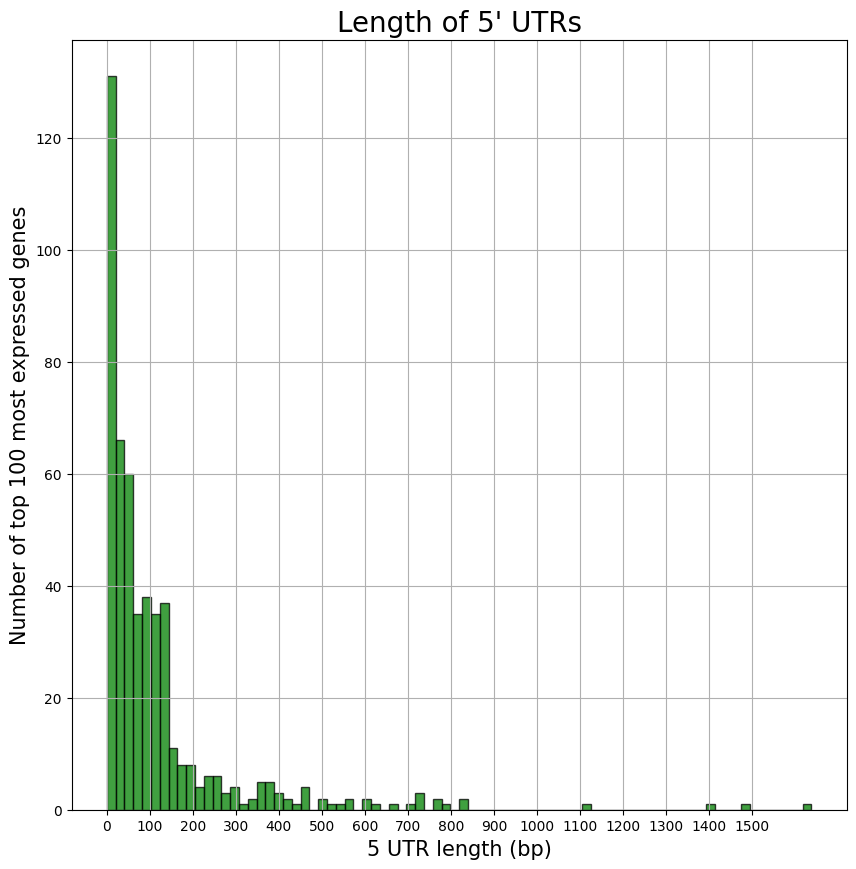

In [ ]:
#Make a histogram of the lengths of the 5' UTRs
plt.figure(figsize=(10,10))
plt.hist(length_list,bins=80,color='green', facecolor='green', alpha=0.75,edgecolor = "black")
plt.xticks(np.arange(0,1600,100))
plt.xlabel("5 UTR length (bp)",fontsize=15)
plt.ylabel("Number of top 100 most expressed genes",fontsize=15)
plt.grid(True)
plt.title("Length of 5' UTRs", fontsize=20)

## Designing primers for doing a combinatorial libary using gibson

In [ ]:
n_genes=10

## load the 5' UTRs and the promoters

path = '/Users/andreasrygaard/Documents/Studie/MSC/Synthetic biology'
kb_upstream = read_fasta_files('100_highest_control_promoters.fasta')
kb_upstream=kb_upstream[:n_genes]
UTRs = read_fasta_files('100_highest_control_promoters_5UTR.fasta')
short_UTRs=read_fasta_files('100_highest_control_promoters_short5UTR.fasta')
GFP=read_fasta_files('GFP_C_reinhardtii.fasta')
GFP[0].id="Codon_optimised_GFP"
GFP[0].name="Codon_optimised_GFP"
GFP[0].description="GFP Codon optimised for reinhardtii"

Uphom=SeqRecord(seq=Seq('CTTCGGTATACAGGCGTGAGCTTCCCCAAGACTGGCCAGACCGTG'),id="down_hom",name="down_hom")
Downhom=SeqRecord(seq=Seq('ACGGCAAGAAGTTCGACAGCTCCCGCGACCGTGGCGAGCCCTTCT'),id="down_hom",name="down_hom")
print(Uphom[0])
print(Downhom)
print(short_UTRs)

## convert into the format of Dseqrecord

kb_upstream= [Dseqrecord(seq) for seq in kb_upstream]
UTRs = [Dseqrecord(seq) for seq in UTRs]
short_UTRs = [Dseqrecord(seq) for seq in short_UTRs]
Uphom= [Dseqrecord(seq) for seq in Uphom]
Downhom=[Dseqrecord(Downhom)]
GFP = [Dseqrecord(GFP[0])]


print("Number of promoters "+str(len(kb_upstream))+" Number of >40 nt UTR: " +str(len(UTRs))+" Number of <40 nt UTRs " + str(len(short_UTRs)))

print(type(Uphom[0]),type(GFP[0]),type(short_UTRs[0]))
#print(Uphom[0],GFP[0])
print(len(Uphom[0].seq),len(GFP[0]),short_UTRs[0].seq)


C
ID: down_hom
Name: down_hom
Description: <unknown description>
Number of features: 0
Seq('ACGGCAAGAAGTTCGACAGCTCCCGCGACCGTGGCGAGCCCTTCT')
[SeqRecord(seq=Seq('GCTCAAACCAAACGCAAAG'), id='UTR_CHLREDRAFT_126163', name='UTR_CHLREDRAFT_126163', description='UTR_CHLREDRAFT_126163 supercontig:v3.1:DS496115:662937:663967:1', dbxrefs=[]), SeqRecord(seq=Seq('CAGAG'), id='UTR_CHLREDRAFT_159282', name='UTR_CHLREDRAFT_159282', description='UTR_CHLREDRAFT_159282 supercontig:v3.1:DS496147:912802:913667:-1', dbxrefs=[]), SeqRecord(seq=Seq('CTCTCTTCTTCAACACGCATCAAA'), id='UTR_CHLREDRAFT_132716', name='UTR_CHLREDRAFT_132716', description='UTR_CHLREDRAFT_132716 supercontig:v3.1:DS496174:109982:110962:-1', dbxrefs=[]), SeqRecord(seq=Seq('CTTAGGGGCTGGGAACGGTGCACAACC'), id='UTR_CHLREDRAFT_195605', name='UTR_CHLREDRAFT_195605', description='UTR_CHLREDRAFT_195605 supercontig:v3.1:DS496110:294356:296924:1', dbxrefs=[]), SeqRecord(seq=Seq('GCCAGACGGTACTGTCGGTTAAATCGATCCCGCGAAG'), id='UTR_CHLREDRAFT_195600', na

We both have long and short promoters (the stadard implementation of DesignAssembly can only pad with 40 bp). We tweak this number to include the 42 bp longest UTR.

### Combinatorial library short and long UTRs

First we do the combinatorial libary with the long UTRs. This is not relevant after we tweaked the DesignAssembly but the code is left here

In [ ]:
# create a list of the 5' UTRs and the promoters
list_of_seqs = [kb_upstream, UTRs,GFP]
#list_of_seqs = [kb_upstream[0:10],UTRs[0:10]]
pad=[Dseqrecord('')]
if len(UTRs)>0:
  Prom_UTR_combinatorial_library = DesignAssembly(list_of_seqs ,list_of_pads=pad,positions_of_pads=[1], overlap=35, target_tm =58 )
  Prom_UTR_combinatorial_library.primer_list_to_dataframe()

Now we do the combinatorial library with the short_URTs as pads:

In [ ]:
list_of_sequences_short = [kb_upstream,GFP]
UTR_padding=short_UTRs
print(UTR_padding[0].seq)


primer_list_df=pd.DataFrame()
pcr_list=pd.DataFrame()
variant_list=pd.DataFrame()
for padding in UTR_padding:
  #print(padding)
  Prom_short_UTR_combinatorial_library = DesignAssembly(list_of_sequences_short ,list_of_pads=[padding],positions_of_pads=[1], overlap=35, target_tm = 58)
  temp_df=Prom_short_UTR_combinatorial_library.primer_list_to_dataframe() #make temp df for primer list
  temp_df["UTR_id"]=[padding.id]*len(temp_df)
  primer_list_df=pd.concat([temp_df,primer_list_df])

  #make temp df for pcr_list
  temp_pcr_list=Prom_short_UTR_combinatorial_library.pcr_list_to_dataframe()
  temp_pcr_list["UTR_id"]=[padding.id]*len(temp_pcr_list)
  pcr_list=pd.concat([temp_pcr_list,pcr_list])

  #make variant list

  temp_variant=Prom_short_UTR_combinatorial_library.show_variants_lib_df()
  temp_variant["UTR_id"]=[padding.id]*len(temp_variant)
  variant_list=pd.concat([temp_variant,variant_list])


GCTCAAACCAAACGCAAAG


### Now we print information about the primers and PCRs

In [ ]:


primer_list_df.to_excel("Primer_list.xlsx")
primer_list_df



id           anneals to  \
0   P001     CHLREDRAFT_46276   
1   P002     CHLREDRAFT_46276   
2   P003  Codon_optimised_GFP   
3   P004  Codon_optimised_GFP   
4   P005    CHLREDRAFT_126163   
..   ...                  ...   
26  P027    CHLREDRAFT_195584   
27  P028  Codon_optimised_GFP   
28  P029    CHLREDRAFT_138697   
29  P030    CHLREDRAFT_138697   
30  P031  Codon_optimised_GFP   

                                             sequence  annealing temperature  \
0    (C, G, G, C, C, G, T, A, G, T, C, T, A, A, A, G)                  57.17   
1   (G, C, C, A, T, T, T, T, T, T, T, G, A, G, C, ...                  57.05   
2   (A, C, C, A, T, G, C, T, T, T, T, T, A, G, G, ...                  58.19   
3   (T, T, A, T, T, T, G, T, A, T, A, A, T, T, C, ...                  57.86   
4    (T, G, A, T, A, G, C, T, A, T, G, G, C, G, G, C)                  59.66   
..                                                ...                    ...   
26  (T, T, T, A, G, C, C, A, T, C, T, T, T, G, C, ...                  55.38   
27  (G, G, C, A, A, A, G, A, T, G, C, T, C, A, A, ...                  58.19   
28            (C, G, G, G, A, G, A, A, G, T, G, G, G)                  55.53   
29  (T, T, T, A, G, C, C, A, T, C, T, T, T, G, C, ...                  55.89   
30  (T, C, T, T, T, G, T, G, C, G, C, T, C, A, A, ...                  58.19   

    length  price(DKK)                                        description  \
0       16        28.8                        Anneals to CHLREDRAFT_46276   
1       48        86.4  Anneals to CHLREDRAFT_46276, overlaps to 757bp...   
2       54        97.2  Anneals to Codon_optimised_GFP, overlaps to CH...   
3       25        45.0                     Anneals to Codon_optimised_GFP   
4       16        28.8                       Anneals to CHLREDRAFT_126163   
..     ...         ...                                                ...   
26      44        79.2  Anneals to CHLREDRAFT_195584, overlaps to 754b...   
27      51        91.8  Anneals to Codon_optimised_GFP, overlaps to CH...   
28      13        23.4                       Anneals to CHLREDRAFT_138697   
29      45        81.0  Anneals to CHLREDRAFT_138697, overlaps to 754b...   
30      51        91.8  Anneals to Codon_optimised_GFP, overlaps to CH...   

                                            footprint  len_footprint  \
0    (C, G, G, C, C, G, T, A, G, T, C, T, A, A, A, G)             16   
1   (A, T, G, G, T, T, G, C, T, A, G, C, T, T, T, ...             17   
2   (A, T, G, G, C, T, A, A, A, G, G, T, G, A, A, ...             23   
3   (T, T, A, T, T, T, G, T, A, T, A, A, T, T, C, ...             25   
4    (T, G, A, T, A, G, C, T, A, T, G, G, C, G, G, C)             16   
..                                                ...            ...   
26   (A, T, C, T, T, T, G, C, C, T, G, C, A, C, A, G)             16   
27  (A, T, G, G, C, T, A, A, A, G, G, T, G, A, A, ...             23   
28            (C, G, G, G, A, G, A, A, G, T, G, G, G)             13   
29  (G, C, A, C, A, A, A, G, A, A, A, G, A, G, G, ...             17   
30  (A, T, G, G, C, T, A, A, A, G, G, T, G, A, A, ...             23   

                   UTR_id  
0   UTR_CHLREDRAFT_195131  
1   UTR_CHLREDRAFT_195131  
2   UTR_CHLREDRAFT_195131  
3   UTR_CHLREDRAFT_195131  
4   UTR_CHLREDRAFT_195131  
..                    ...  
26  UTR_CHLREDRAFT_126163  
27  UTR_CHLREDRAFT_126163  
28  UTR_CHLREDRAFT_126163  
29  UTR_CHLREDRAFT_126163  
30  UTR_CHLREDRAFT_126163  

[283 rows x 10 columns]

In [ ]:
print(sum(primer_list_df["price(DKK)"]))
pcr_list


18795.59999999999


pcr_number             template forward_primer reverse_primer   f_tm  \
0        PCR1     CHLREDRAFT_46276           P001           P002  57.17   
1        PCR2  Codon_optimised_GFP           P003           P004  58.19   
2        PCR3    CHLREDRAFT_126163           P005           P006  59.66   
3        PCR4  Codon_optimised_GFP           P007           P004  58.19   
4        PCR5    CHLREDRAFT_159282           P008           P009  57.54   
..        ...                  ...            ...            ...    ...   
15      PCR16  Codon_optimised_GFP           P025           P004  58.19   
16      PCR17    CHLREDRAFT_195584           P026           P027  56.28   
17      PCR18  Codon_optimised_GFP           P028           P004  58.19   
18      PCR19    CHLREDRAFT_138697           P029           P030  55.53   
19      PCR20  Codon_optimised_GFP           P031           P004  58.19   

     r_tm                 UTR_id  
0   57.05  UTR_CHLREDRAFT_195131  
1   57.86  UTR_CHLREDRAFT_195131  
2   60.03  UTR_CHLREDRAFT_195131  
3   57.86  UTR_CHLREDRAFT_195131  
4   56.19  UTR_CHLREDRAFT_195131  
..    ...                    ...  
15  57.86  UTR_CHLREDRAFT_126163  
16  55.38  UTR_CHLREDRAFT_126163  
17  57.86  UTR_CHLREDRAFT_126163  
18  55.89  UTR_CHLREDRAFT_126163  
19  57.86  UTR_CHLREDRAFT_126163  

[173 rows x 7 columns]

In [ ]:
variant_list

0                    1 Systematic_name  Variant  \
0    CHLREDRAFT_46276  Codon_optimised_GFP          (1, 1)        0   
1   CHLREDRAFT_126163  Codon_optimised_GFP          (2, 1)        1   
2   CHLREDRAFT_159282  Codon_optimised_GFP          (3, 1)        2   
3   CHLREDRAFT_132716  Codon_optimised_GFP          (4, 1)        3   
4    CHLREDRAFT_82172  Codon_optimised_GFP          (5, 1)        4   
..                ...                  ...             ...      ...   
5   CHLREDRAFT_195605  Codon_optimised_GFP          (6, 1)        5   
6   CHLREDRAFT_195600  Codon_optimised_GFP          (7, 1)        6   
7   CHLREDRAFT_142065  Codon_optimised_GFP          (8, 1)        7   
8   CHLREDRAFT_195584  Codon_optimised_GFP          (9, 1)        8   
9   CHLREDRAFT_138697  Codon_optimised_GFP         (10, 1)        9   

                   UTR_id  
0   UTR_CHLREDRAFT_195131  
1   UTR_CHLREDRAFT_195131  
2   UTR_CHLREDRAFT_195131  
3   UTR_CHLREDRAFT_195131  
4   UTR_CHLREDRAFT_195131  
..                    ...  
5   UTR_CHLREDRAFT_126163  
6   UTR_CHLREDRAFT_126163  
7   UTR_CHLREDRAFT_126163  
8   UTR_CHLREDRAFT_126163  
9   UTR_CHLREDRAFT_126163  

[100 rows x 5 columns]

In [ ]:
Prom_short_UTR_combinatorial_library.show_variants_lib_df()

0                    1 Systematic_name  Variant
0   CHLREDRAFT_46276  Codon_optimised_GFP          (1, 1)        0
1  CHLREDRAFT_126163  Codon_optimised_GFP          (2, 1)        1
2  CHLREDRAFT_159282  Codon_optimised_GFP          (3, 1)        2
3  CHLREDRAFT_132716  Codon_optimised_GFP          (4, 1)        3
4   CHLREDRAFT_82172  Codon_optimised_GFP          (5, 1)        4
5  CHLREDRAFT_195605  Codon_optimised_GFP          (6, 1)        5
6  CHLREDRAFT_195600  Codon_optimised_GFP          (7, 1)        6
7  CHLREDRAFT_142065  Codon_optimised_GFP          (8, 1)        7
8  CHLREDRAFT_195584  Codon_optimised_GFP          (9, 1)        8
9  CHLREDRAFT_138697  Codon_optimised_GFP         (10, 1)        9